# Quickstart Example of Advanced Off-Policy Evaluation and Selection (continuous)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic simulation dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [2]:
# delete later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [4]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [5]:
# import OFRL modules
import ofrl
from syntheticgym import SyntheticEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [6]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
# version
print(ofrl.__version__)

0.0.0


In [8]:
# set random state
random_state = 12345

In [9]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the Synthetic environment works.

#### RL setup for Synthetic
In Synthetic, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this Synthetic problem as the following Constrained Markov Decision Process (CMDP):
- `state`: 
- `action`: 
- `reward`: 

<!-- For more about the environmental configuration and its customization, please refer to [examples/quickstart/synthetic_synthetic_customize_env.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_customize_env.ipynb). -->

In [10]:
# standardized environment for continuous action
# env = gym.make("SyntheticEnv-continuous-v0")
env = SyntheticEnv(action_type='continuous', random_state=random_state)

In [11]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Synthetic environment for RL defined in the previous section.
- `state_keys`: Name of the state variable at each dimension.
- `max_episode_steps`: Maximum number of timesteps in an episode.
- `info_keys`: Dictionary containing of key and the type of info components.

For more about the data collection and visualization, please refer to [examples/quickstart/synthetic_synthetic_data_collection.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_data_collection.ipynb).

In [12]:
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        # minimum=0.1,   # 0.1
        # maximum=10,  # 10
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [13]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=10000,
    n_steps_per_epoch=100,
    update_start_step=100,
    # n_steps=100000,
    # n_steps_per_epoch=1000,
    # update_start_step=1000,
)

2023-03-10 07:34.52 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230310073452
2023-03-10 07:34.52 [debug    ] Fitting action scaler...       action_scler=min_max
2023-03-10 07:34.52 [debug    ] Building model...
2023-03-10 07:34.52 [debug    ] Model has been built.
2023-03-10 07:34.52 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230310073452/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 07:34.52 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230310073452/model_100.pt
2023-03-10 07:34.52 [info     ] SAC_online_20230310073452: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0003116774559020996, 'time_environment_step': 2.46429443359375e-05, 'time_step': 0.00034836292266845706, 'rollout_return': 24.790698823307604, 'evaluation': 24.526120320535206} step=100
2023-03-10 07:34.52 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230310073452/model_200.pt
2023-03-10 07:34.52 [info     ] SAC_online_20230310073452: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00028145790100097656, 'time_environment_step': 2.0558834075927735e-05, 'time_step': 0.0003138518333435059, 'rollout_return': 24.27838348357389, 'evaluation': 24.869464014211665} step=200
2023-03-10 07:34.52 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230310073452/model_300.pt
2023-03-10 07:34.52 [info     ] SAC_online_20230310073452: epo

In [14]:
# save model
sac.save_model("d3rlpy_logs/synthetic_sac.pt")

In [15]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/synthetic_sac.pt")

2023-03-10 07:35.36 [warning  ] Parameters will be reinitialized.


In [16]:
behavior_policy_05 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([0.5]),
    name="sac_sigma_0.5",
    random_state=random_state,
)
behavior_policy_10 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)
behavior_policy_20 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([2.0]),
    name="sac_sigma_2.0",
    random_state=random_state,
)
behavior_policies = [behavior_policy_05, behavior_policy_10, behavior_policy_20]

In [17]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [18]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=5, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    path="synthetic/logged_dataset/",
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=5, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    path="synthetic/logged_dataset/",
    random_state=random_state + 1,
)

[obtain_datasets: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
with open("logs/train_dataset_continuous_synthetic_sac_5.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_synthetic_sac_5.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [20]:
with open("logs/train_dataset_continuous_synthetic_sac_5.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_synthetic_sac_5.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/synthetic_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_basic.ipynb).

In [21]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import CQL, IQL

In [22]:
# evaluation policies
cql_b1 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b2 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b3 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b1 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b2 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b3 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

algorithms = [cql_b1, cql_b2, cql_b3, iql_b1, iql_b2, iql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3", "iql_b1", "iql_b2", "iql_b3"]

In [23]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [24]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 07:48.44 [debug    ] RandomIterator is selected.
2023-03-10 07:48.44 [info     ] Directory is created at d3rlpy_logs/CQL_20230310074844
2023-03-10 07:48.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 07:48.44 [debug    ] Building models...
2023-03-10 07:48.44 [debug    ] Models have been built.
2023-03-10 07:48.44 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310074844/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 07:51.33 [info     ] CQL_20230310074844: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005547783851623535, 'time_algorithm_update': 0.015907097482681275, 'temp_loss': 0.7527349979990627, 'temp': 0.7919775098502636, 'alpha_loss': 2.643610304185841, 'alpha': 0.7594327055871487, 'critic_loss': 234.09717082114219, 'actor_loss': -33.41662776846886, 'time_step': 0.016863887047767638} step=10000
2023-03-10 07:51.33 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310074844/model_10000.pt
2023-03-10 07:51.33 [debug    ] RandomIterator is selected.
2023-03-10 07:51.33 [info     ] Directory is created at d3rlpy_logs/CQL_20230310075133
2023-03-10 07:51.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 07:51.33 [debug    ] Building models...
2023-03-10 07:51.33 [debug    ] Models have been built.
2023-03-10 07:51.33 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310075133/params.json params={'action_scaler': {'type': 'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 07:54.14 [info     ] CQL_20230310075133: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005649287939071655, 'time_algorithm_update': 0.015029912734031677, 'temp_loss': 0.9059431606348138, 'temp': 0.7549269788622857, 'alpha_loss': 0.9449865825667279, 'alpha': 0.8405089155077934, 'critic_loss': 247.0790931649208, 'actor_loss': -35.10193847055435, 'time_step': 0.016011059260368346} step=10000
2023-03-10 07:54.14 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310075133/model_10000.pt
2023-03-10 07:54.14 [debug    ] RandomIterator is selected.
2023-03-10 07:54.14 [info     ] Directory is created at d3rlpy_logs/CQL_20230310075414
2023-03-10 07:54.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 07:54.14 [debug    ] Building models...
2023-03-10 07:54.14 [debug    ] Models have been built.
2023-03-10 07:54.14 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310075414/params.json params={'action_scaler': {'type': 'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 07:56.43 [info     ] CQL_20230310075414: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005530651569366455, 'time_algorithm_update': 0.01380163459777832, 'temp_loss': 0.8398458466291194, 'temp': 0.7919928473889828, 'alpha_loss': 2.312890054204734, 'alpha': 0.7804859192252159, 'critic_loss': 212.83440494995116, 'actor_loss': -31.11196846189499, 'time_step': 0.01476421058177948} step=10000
2023-03-10 07:56.43 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310075414/model_10000.pt
2023-03-10 07:56.43 [debug    ] RandomIterator is selected.
2023-03-10 07:56.43 [info     ] Directory is created at d3rlpy_logs/IQL_20230310075643
2023-03-10 07:56.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 07:56.43 [debug    ] Building models...
2023-03-10 07:56.43 [debug    ] Models have been built.
2023-03-10 07:56.43 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310075643/params.json params={'action_scaler': {'type': 'min_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 07:57.29 [info     ] IQL_20230310075643: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005232548236846924, 'time_algorithm_update': 0.0038530503034591673, 'critic_loss': 170.38006018099784, 'value_loss': 0.25688929010771755, 'actor_loss': -10.77100574093135, 'time_step': 0.004638789439201355} step=10000
2023-03-10 07:57.30 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310075643/model_10000.pt
2023-03-10 07:57.30 [debug    ] RandomIterator is selected.
2023-03-10 07:57.30 [info     ] Directory is created at d3rlpy_logs/IQL_20230310075730
2023-03-10 07:57.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 07:57.30 [debug    ] Building models...
2023-03-10 07:57.30 [debug    ] Models have been built.
2023-03-10 07:57.30 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310075730/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 07:58.15 [info     ] IQL_20230310075730: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005241160869598389, 'time_algorithm_update': 0.0036950040817260743, 'critic_loss': 185.576263986969, 'value_loss': 0.3269324060406332, 'actor_loss': -13.767635701123998, 'time_step': 0.004472079014778137} step=10000
2023-03-10 07:58.15 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310075730/model_10000.pt
2023-03-10 07:58.15 [debug    ] RandomIterator is selected.
2023-03-10 07:58.15 [info     ] Directory is created at d3rlpy_logs/IQL_20230310075815
2023-03-10 07:58.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 07:58.15 [debug    ] Building models...
2023-03-10 07:58.15 [debug    ] Models have been built.
2023-03-10 07:58.15 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310075815/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 07:59.00 [info     ] IQL_20230310075815: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000513649320602417, 'time_algorithm_update': 0.003756135869026184, 'critic_loss': 185.23699736802578, 'value_loss': 0.31045927907534204, 'actor_loss': -11.624985174123012, 'time_step': 0.004518289971351623} step=10000
2023-03-10 07:59.00 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310075815/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 07:59.00 [debug    ] RandomIterator is selected.
2023-03-10 07:59.00 [info     ] Directory is created at d3rlpy_logs/CQL_20230310075900
2023-03-10 07:59.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 07:59.00 [warning  ] Skip building models since they're already built.
2023-03-10 07:59.00 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310075900/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:02.01 [info     ] CQL_20230310075900: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005961694717407227, 'time_algorithm_update': 0.016944502019882204, 'temp_loss': 0.029798261892586015, 'temp': 0.5329509060174227, 'alpha_loss': 0.5142748799677771, 'alpha': 0.3611734893321991, 'critic_loss': 354.7985176696777, 'actor_loss': -46.54055078277588, 'time_step': 0.018002545523643495} step=10000
2023-03-10 08:02.01 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310075900/model_10000.pt
2023-03-10 08:02.01 [debug    ] RandomIterator is selected.
2023-03-10 08:02.01 [info     ] Directory is created at d3rlpy_logs/CQL_20230310080201
2023-03-10 08:02.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:02.01 [warning  ] Skip building models since they're already built.
2023-03-10 08:02.01 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310080201/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:05.18 [info     ] CQL_20230310080201: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007186758756637573, 'time_algorithm_update': 0.018279346919059754, 'temp_loss': 0.018560796460707206, 'temp': 0.5326215241372585, 'alpha_loss': 0.22387859834067075, 'alpha': 0.4733757441163063, 'critic_loss': 422.72822149353027, 'actor_loss': -50.250181954956055, 'time_step': 0.01949958267211914} step=10000
2023-03-10 08:05.18 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310080201/model_10000.pt
2023-03-10 08:05.18 [debug    ] RandomIterator is selected.
2023-03-10 08:05.18 [info     ] Directory is created at d3rlpy_logs/CQL_20230310080518
2023-03-10 08:05.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:05.18 [warning  ] Skip building models since they're already built.
2023-03-10 08:05.18 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310080518/params.json params={'action_scaler': {'type': 'min_max', 'params': {'m

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:08.18 [info     ] CQL_20230310080518: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007052076578140259, 'time_algorithm_update': 0.016684345984458924, 'temp_loss': 0.025537590659921987, 'temp': 0.6474635808587075, 'alpha_loss': 0.30114788268288795, 'alpha': 0.4196136658489704, 'critic_loss': 404.71064336242677, 'actor_loss': -49.15388042449951, 'time_step': 0.01789762303829193} step=10000
2023-03-10 08:08.18 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310080518/model_10000.pt
2023-03-10 08:08.18 [debug    ] RandomIterator is selected.
2023-03-10 08:08.18 [info     ] Directory is created at d3rlpy_logs/IQL_20230310080818
2023-03-10 08:08.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:08.18 [warning  ] Skip building models since they're already built.
2023-03-10 08:08.18 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310080818/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:09.14 [info     ] IQL_20230310080818: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006527819633483886, 'time_algorithm_update': 0.0045529428482055665, 'critic_loss': 198.7200788696289, 'value_loss': 0.17978584283217788, 'actor_loss': -9.667929172444344, 'time_step': 0.005516142988204956} step=10000
2023-03-10 08:09.14 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310080818/model_10000.pt
2023-03-10 08:09.14 [debug    ] RandomIterator is selected.
2023-03-10 08:09.14 [info     ] Directory is created at d3rlpy_logs/IQL_20230310080914
2023-03-10 08:09.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:09.14 [warning  ] Skip building models since they're already built.
2023-03-10 08:09.14 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310080914/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fact

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:10.05 [info     ] IQL_20230310080914: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000647338056564331, 'time_algorithm_update': 0.004188203358650207, 'critic_loss': 227.40725355148317, 'value_loss': 0.2403450147420168, 'actor_loss': -12.24203908276558, 'time_step': 0.005144328641891479} step=10000
2023-03-10 08:10.05 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310080914/model_10000.pt
2023-03-10 08:10.05 [debug    ] RandomIterator is selected.
2023-03-10 08:10.05 [info     ] Directory is created at d3rlpy_logs/IQL_20230310081005
2023-03-10 08:10.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:10.05 [warning  ] Skip building models since they're already built.
2023-03-10 08:10.05 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310081005/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factor

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:11.01 [info     ] IQL_20230310081005: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006490888595581055, 'time_algorithm_update': 0.004509552907943725, 'critic_loss': 230.9065735824585, 'value_loss': 0.2070782522253692, 'actor_loss': -10.187595029449463, 'time_step': 0.005468509387969971} step=10000
2023-03-10 08:11.01 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310081005/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 08:11.01 [debug    ] RandomIterator is selected.
2023-03-10 08:11.01 [info     ] Directory is created at d3rlpy_logs/CQL_20230310081101
2023-03-10 08:11.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:11.01 [warning  ] Skip building models since they're already built.
2023-03-10 08:11.01 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310081101/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:14.35 [info     ] CQL_20230310081101: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007140225410461426, 'time_algorithm_update': 0.020057710433006287, 'temp_loss': 0.03514547548680566, 'temp': 0.3392113827764988, 'alpha_loss': -0.7165283731902251, 'alpha': 0.49038850395679473, 'critic_loss': 275.93962247161863, 'actor_loss': -41.09175106811524, 'time_step': 0.021283664774894715} step=10000
2023-03-10 08:14.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310081101/model_10000.pt
2023-03-10 08:14.35 [debug    ] RandomIterator is selected.
2023-03-10 08:14.35 [info     ] Directory is created at d3rlpy_logs/CQL_20230310081435
2023-03-10 08:14.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:14.35 [warning  ] Skip building models since they're already built.
2023-03-10 08:14.35 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310081435/params.json params={'action_scaler': {'type': 'min_max', 'params': {'m

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:18.07 [info     ] CQL_20230310081435: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007414278030395508, 'time_algorithm_update': 0.01974226517677307, 'temp_loss': 0.04967581438630587, 'temp': 0.3328653171747923, 'alpha_loss': -0.4806239805796507, 'alpha': 0.630962275353074, 'critic_loss': 340.1903266067505, 'actor_loss': -45.20184975166321, 'time_step': 0.02104054090976715} step=10000
2023-03-10 08:18.07 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310081435/model_10000.pt
2023-03-10 08:18.07 [debug    ] RandomIterator is selected.
2023-03-10 08:18.07 [info     ] Directory is created at d3rlpy_logs/CQL_20230310081807
2023-03-10 08:18.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:18.07 [warning  ] Skip building models since they're already built.
2023-03-10 08:18.07 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310081807/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimu

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:21.21 [info     ] CQL_20230310081807: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007068308353424072, 'time_algorithm_update': 0.018065712785720826, 'temp_loss': 0.11215612498666742, 'temp': 0.34716134513020513, 'alpha_loss': -0.4149063987235568, 'alpha': 0.5204904122203589, 'critic_loss': 266.0250827774048, 'actor_loss': -40.35443818283081, 'time_step': 0.019292519998550414} step=10000
2023-03-10 08:21.21 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310081807/model_10000.pt
2023-03-10 08:21.21 [debug    ] RandomIterator is selected.
2023-03-10 08:21.21 [info     ] Directory is created at d3rlpy_logs/IQL_20230310082121
2023-03-10 08:21.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:21.21 [warning  ] Skip building models since they're already built.
2023-03-10 08:21.21 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310082121/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:22.17 [info     ] IQL_20230310082121: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006364542245864868, 'time_algorithm_update': 0.004509881901741028, 'critic_loss': 169.39917374420165, 'value_loss': 0.2197353696525097, 'actor_loss': -5.806914453200996, 'time_step': 0.005464406156539917} step=10000
2023-03-10 08:22.17 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310082121/model_10000.pt
2023-03-10 08:22.17 [debug    ] RandomIterator is selected.
2023-03-10 08:22.17 [info     ] Directory is created at d3rlpy_logs/IQL_20230310082217
2023-03-10 08:22.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:22.17 [warning  ] Skip building models since they're already built.
2023-03-10 08:22.17 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310082217/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_facto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:23.08 [info     ] IQL_20230310082217: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006331925868988037, 'time_algorithm_update': 0.004161532926559448, 'critic_loss': 209.28618873062135, 'value_loss': 0.319816887332499, 'actor_loss': -9.1156437702775, 'time_step': 0.00510885238647461} step=10000
2023-03-10 08:23.08 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310082217/model_10000.pt
2023-03-10 08:23.08 [debug    ] RandomIterator is selected.
2023-03-10 08:23.08 [info     ] Directory is created at d3rlpy_logs/IQL_20230310082308
2023-03-10 08:23.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:23.08 [warning  ] Skip building models since they're already built.
2023-03-10 08:23.08 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310082308/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory':

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:24.05 [info     ] IQL_20230310082308: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006476666212081909, 'time_algorithm_update': 0.004668117833137512, 'critic_loss': 209.2673635826111, 'value_loss': 0.24452646000906825, 'actor_loss': -6.475725448046624, 'time_step': 0.005638532876968384} step=10000
2023-03-10 08:24.05 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310082308/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 08:24.05 [debug    ] RandomIterator is selected.
2023-03-10 08:24.05 [info     ] Directory is created at d3rlpy_logs/CQL_20230310082405
2023-03-10 08:24.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:24.05 [warning  ] Skip building models since they're already built.
2023-03-10 08:24.05 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310082405/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:27.31 [info     ] CQL_20230310082405: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006818601608276368, 'time_algorithm_update': 0.01927584409713745, 'temp_loss': -0.0021605379145476036, 'temp': 0.34276593673229216, 'alpha_loss': 0.003900244079505501, 'alpha': 0.6766582966148853, 'critic_loss': 241.04342916412352, 'actor_loss': -39.02863260345459, 'time_step': 0.02047072105407715} step=10000
2023-03-10 08:27.31 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310082405/model_10000.pt
2023-03-10 08:27.31 [debug    ] RandomIterator is selected.
2023-03-10 08:27.31 [info     ] Directory is created at d3rlpy_logs/CQL_20230310082731
2023-03-10 08:27.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:27.31 [warning  ] Skip building models since they're already built.
2023-03-10 08:27.31 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310082731/params.json params={'action_scaler': {'type': 'min_max', 'params': {

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:30.56 [info     ] CQL_20230310082731: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007124262809753418, 'time_algorithm_update': 0.019084261393547058, 'temp_loss': 0.003529175924125593, 'temp': 0.2626249359279871, 'alpha_loss': 0.03941552745152585, 'alpha': 0.5528221857786179, 'critic_loss': 278.72345040130614, 'actor_loss': -41.62224097366333, 'time_step': 0.020318748259544373} step=10000
2023-03-10 08:30.56 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310082731/model_10000.pt
2023-03-10 08:30.56 [debug    ] RandomIterator is selected.
2023-03-10 08:30.56 [info     ] Directory is created at d3rlpy_logs/CQL_20230310083056
2023-03-10 08:30.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:30.56 [warning  ] Skip building models since they're already built.
2023-03-10 08:30.56 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310083056/params.json params={'action_scaler': {'type': 'min_max', 'params': {'m

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:34.04 [info     ] CQL_20230310083056: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007032321453094482, 'time_algorithm_update': 0.01750220513343811, 'temp_loss': -0.0010725110007915647, 'temp': 0.26818902516961096, 'alpha_loss': 0.009596699284509668, 'alpha': 0.49337983844578265, 'critic_loss': 228.5416977645874, 'actor_loss': -38.21591388854981, 'time_step': 0.018719985938072205} step=10000
2023-03-10 08:34.04 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310083056/model_10000.pt
2023-03-10 08:34.04 [debug    ] RandomIterator is selected.
2023-03-10 08:34.04 [info     ] Directory is created at d3rlpy_logs/IQL_20230310083404
2023-03-10 08:34.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:34.04 [warning  ] Skip building models since they're already built.
2023-03-10 08:34.04 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310083404/params.json params={'action_scaler': {'type': 'min_max', 'params': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:35.05 [info     ] IQL_20230310083404: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006657324075698852, 'time_algorithm_update': 0.005020851182937622, 'critic_loss': 159.64787409362793, 'value_loss': 0.1733305092178285, 'actor_loss': -4.671934239697457, 'time_step': 0.006011147451400757} step=10000
2023-03-10 08:35.05 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310083404/model_10000.pt
2023-03-10 08:35.05 [debug    ] RandomIterator is selected.
2023-03-10 08:35.05 [info     ] Directory is created at d3rlpy_logs/IQL_20230310083505
2023-03-10 08:35.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:35.05 [warning  ] Skip building models since they're already built.
2023-03-10 08:35.05 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310083505/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_facto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:35.56 [info     ] IQL_20230310083505: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006308692693710327, 'time_algorithm_update': 0.004167362189292908, 'critic_loss': 197.99688380966185, 'value_loss': 0.21311989998221398, 'actor_loss': -6.009022393131256, 'time_step': 0.005099575257301331} step=10000
2023-03-10 08:35.56 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310083505/model_10000.pt
2023-03-10 08:35.57 [debug    ] RandomIterator is selected.
2023-03-10 08:35.57 [info     ] Directory is created at d3rlpy_logs/IQL_20230310083557
2023-03-10 08:35.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:35.57 [warning  ] Skip building models since they're already built.
2023-03-10 08:35.57 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310083557/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fact

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:36.51 [info     ] IQL_20230310083557: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006315179109573364, 'time_algorithm_update': 0.004453961443901062, 'critic_loss': 199.93829670028686, 'value_loss': 0.16272198232263327, 'actor_loss': -4.267090144048631, 'time_step': 0.005383099102973938} step=10000
2023-03-10 08:36.51 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310083557/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 08:36.51 [debug    ] RandomIterator is selected.
2023-03-10 08:36.51 [info     ] Directory is created at d3rlpy_logs/CQL_20230310083651
2023-03-10 08:36.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:36.51 [warning  ] Skip building models since they're already built.
2023-03-10 08:36.51 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310083651/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:40.31 [info     ] CQL_20230310083651: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007074448347091675, 'time_algorithm_update': 0.02061129570007324, 'temp_loss': 0.05543457195038209, 'temp': 0.23636789585202933, 'alpha_loss': -7.111322653841972, 'alpha': 1.2666761319458484, 'critic_loss': 274.94218709869386, 'actor_loss': -40.302939261245726, 'time_step': 0.021849229049682617} step=10000
2023-03-10 08:40.31 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310083651/model_10000.pt
2023-03-10 08:40.31 [debug    ] RandomIterator is selected.
2023-03-10 08:40.31 [info     ] Directory is created at d3rlpy_logs/CQL_20230310084031
2023-03-10 08:40.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:40.31 [warning  ] Skip building models since they're already built.
2023-03-10 08:40.31 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310084031/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:43.53 [info     ] CQL_20230310084031: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007097995042800903, 'time_algorithm_update': 0.018813414812088012, 'temp_loss': 0.07892841184872668, 'temp': 0.16657240499854087, 'alpha_loss': -5.341073778009415, 'alpha': 1.0098069798231124, 'critic_loss': 247.03237934036255, 'actor_loss': -38.503897063827516, 'time_step': 0.020047297835350038} step=10000
2023-03-10 08:43.53 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310084031/model_10000.pt
2023-03-10 08:43.53 [debug    ] RandomIterator is selected.
2023-03-10 08:43.53 [info     ] Directory is created at d3rlpy_logs/CQL_20230310084353
2023-03-10 08:43.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:43.53 [warning  ] Skip building models since they're already built.
2023-03-10 08:43.53 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310084353/params.json params={'action_scaler': {'type': 'min_max', 'params': {'m

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:47.15 [info     ] CQL_20230310084353: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007234813928604126, 'time_algorithm_update': 0.018804125738143922, 'temp_loss': 0.09917312743926013, 'temp': 0.17289843251258136, 'alpha_loss': -5.198357671999931, 'alpha': 0.9570638103038073, 'critic_loss': 233.54738911132813, 'actor_loss': -37.3722069934845, 'time_step': 0.020068391156196595} step=10000
2023-03-10 08:47.15 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310084353/model_10000.pt
2023-03-10 08:47.15 [debug    ] RandomIterator is selected.
2023-03-10 08:47.15 [info     ] Directory is created at d3rlpy_logs/IQL_20230310084715
2023-03-10 08:47.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:47.15 [warning  ] Skip building models since they're already built.
2023-03-10 08:47.15 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310084715/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:48.14 [info     ] IQL_20230310084715: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006579976081848145, 'time_algorithm_update': 0.00490380494594574, 'critic_loss': 155.50907567214966, 'value_loss': 0.2833354391261935, 'actor_loss': 0.5518580131277442, 'time_step': 0.005890803527832032} step=10000
2023-03-10 08:48.14 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310084715/model_10000.pt
2023-03-10 08:48.14 [debug    ] RandomIterator is selected.
2023-03-10 08:48.14 [info     ] Directory is created at d3rlpy_logs/IQL_20230310084814
2023-03-10 08:48.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:48.14 [warning  ] Skip building models since they're already built.
2023-03-10 08:48.14 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310084814/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factor

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:49.09 [info     ] IQL_20230310084814: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006506373643875122, 'time_algorithm_update': 0.004467073702812195, 'critic_loss': 174.85909852142333, 'value_loss': 0.26484587386399505, 'actor_loss': 0.12446638692729176, 'time_step': 0.005448147749900818} step=10000
2023-03-10 08:49.09 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310084814/model_10000.pt
2023-03-10 08:49.09 [debug    ] RandomIterator is selected.
2023-03-10 08:49.09 [info     ] Directory is created at d3rlpy_logs/IQL_20230310084909
2023-03-10 08:49.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:49.09 [warning  ] Skip building models since they're already built.
2023-03-10 08:49.09 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310084909/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fac

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:50.07 [info     ] IQL_20230310084909: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006418262243270874, 'time_algorithm_update': 0.004740153932571411, 'critic_loss': 172.8811598968506, 'value_loss': 0.2220744772553444, 'actor_loss': 0.17717809380292893, 'time_step': 0.0057058224678039554} step=10000
2023-03-10 08:50.07 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310084909/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 08:50.07 [debug    ] RandomIterator is selected.
2023-03-10 08:50.07 [info     ] Directory is created at d3rlpy_logs/CQL_20230310085007
2023-03-10 08:50.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:50.07 [warning  ] Skip building models since they're already built.
2023-03-10 08:50.07 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310085007/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:53.35 [info     ] CQL_20230310085007: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006867525815963745, 'time_algorithm_update': 0.019425073099136353, 'temp_loss': 0.003047987092129188, 'temp': 0.1915166892081499, 'alpha_loss': -17.321120385742187, 'alpha': 3.7390805588722227, 'critic_loss': 265.75311679229736, 'actor_loss': -39.27294912109375, 'time_step': 0.02061605942249298} step=10000
2023-03-10 08:53.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310085007/model_10000.pt
2023-03-10 08:53.35 [debug    ] RandomIterator is selected.
2023-03-10 08:53.35 [info     ] Directory is created at d3rlpy_logs/CQL_20230310085335
2023-03-10 08:53.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:53.35 [warning  ] Skip building models since they're already built.
2023-03-10 08:53.35 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310085335/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 08:56.57 [info     ] CQL_20230310085335: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007015611886978149, 'time_algorithm_update': 0.018843906307220458, 'temp_loss': 0.005723066126200138, 'temp': 0.13397031271234155, 'alpha_loss': -12.121668999052048, 'alpha': 2.959024373435974, 'critic_loss': 248.37877666168214, 'actor_loss': -38.27312363395691, 'time_step': 0.02005728061199188} step=10000
2023-03-10 08:56.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310085335/model_10000.pt
2023-03-10 08:56.57 [debug    ] RandomIterator is selected.
2023-03-10 08:56.57 [info     ] Directory is created at d3rlpy_logs/CQL_20230310085657
2023-03-10 08:56.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 08:56.57 [warning  ] Skip building models since they're already built.
2023-03-10 08:56.57 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310085657/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 09:00.01 [info     ] CQL_20230310085657: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006927066087722778, 'time_algorithm_update': 0.01715428879261017, 'temp_loss': 0.003674839315490681, 'temp': 0.11878781141117215, 'alpha_loss': -10.979910156059265, 'alpha': 2.7855183316469194, 'critic_loss': 223.73112909545898, 'actor_loss': -36.3711878742218, 'time_step': 0.01835251817703247} step=10000
2023-03-10 09:00.01 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310085657/model_10000.pt
2023-03-10 09:00.01 [debug    ] RandomIterator is selected.
2023-03-10 09:00.01 [info     ] Directory is created at d3rlpy_logs/IQL_20230310090001
2023-03-10 09:00.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 09:00.01 [warning  ] Skip building models since they're already built.
2023-03-10 09:00.01 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310090001/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 09:01.00 [info     ] IQL_20230310090001: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006373547554016113, 'time_algorithm_update': 0.004868234443664551, 'critic_loss': 154.01623112716675, 'value_loss': 0.23902567065954208, 'actor_loss': -0.22293734645973892, 'time_step': 0.005837449193000793} step=10000
2023-03-10 09:01.00 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310090001/model_10000.pt
2023-03-10 09:01.00 [debug    ] RandomIterator is selected.
2023-03-10 09:01.00 [info     ] Directory is created at d3rlpy_logs/IQL_20230310090100
2023-03-10 09:01.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 09:01.00 [warning  ] Skip building models since they're already built.
2023-03-10 09:01.00 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310090100/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fa

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 09:02.03 [info     ] IQL_20230310090100: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006400511980056763, 'time_algorithm_update': 0.005202936697006225, 'critic_loss': 164.53613117904663, 'value_loss': 0.21426150170713662, 'actor_loss': -0.4560940450499766, 'time_step': 0.006204598522186279} step=10000
2023-03-10 09:02.03 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310090100/model_10000.pt
2023-03-10 09:02.03 [debug    ] RandomIterator is selected.
2023-03-10 09:02.03 [info     ] Directory is created at d3rlpy_logs/IQL_20230310090203
2023-03-10 09:02.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 09:02.03 [warning  ] Skip building models since they're already built.
2023-03-10 09:02.03 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310090203/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fac

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 09:03.07 [info     ] IQL_20230310090203: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007004032611846924, 'time_algorithm_update': 0.005299770402908325, 'critic_loss': 165.16448417510986, 'value_loss': 0.18545680401325226, 'actor_loss': -0.29124979294885417, 'time_step': 0.006353859877586365} step=10000
2023-03-10 09:03.07 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310090203/model_10000.pt


In [ ]:
with open("d3rlpy_logs/multiple_continuous_synthetic_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [ ]:
with open("d3rlpy_logs/multiple_continuous_synthetic_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [ ]:
# policy wrapper
policy_wrappers = {
    "gauss_05": (
        TruncatedGaussianHead, {
            "sigma": np.array([0.5]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
    "gauss_10": (
        TruncatedGaussianHead, {
            "sigma": np.array([1.0]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
}

In [ ]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [ ]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_gauss_05',
 'cql_b1_gauss_10',
 'cql_b2_gauss_05',
 'cql_b2_gauss_10',
 'cql_b3_gauss_05',
 'cql_b3_gauss_10',
 'iql_b1_gauss_05',
 'iql_b1_gauss_10',
 'iql_b2_gauss_05',
 'iql_b2_gauss_10',
 'iql_b3_gauss_05',
 'iql_b3_gauss_10']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [ ]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [ ]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [ ]:
test_logged_dataset.behavior_policy_names

['sac_sigma_0.5', 'sac_sigma_1.0', 'sac_sigma_2.0']

In [ ]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    path="synthetic/input_dict/",
    random_state=random_state,
)

[collect input data: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-08 18:39.59 [debug    ] RoundIterator is selected.
2023-03-08 18:39.59 [info     ] Directory is created at d3rlpy_logs/FQE_20230308183959
2023-03-08 18:39.59 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:39.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:39.59 [debug    ] Building models...
2023-03-08 18:39.59 [debug    ] Models have been built.
2023-03-08 18:39.59 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308183959/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.02 [info     ] FQE_20230308183959: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015195417404174804, 'time_algorithm_update': 0.0018514833450317383, 'loss': 8490.106567626954, 'time_step': 0.0020786521434783935} step=1000
2023-03-08 18:40.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308183959/model_1000.pt
2023-03-08 18:40.02 [debug    ] RoundIterator is selected.
2023-03-08 18:40.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184002
2023-03-08 18:40.02 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.02 [debug    ] Building models...
2023-03-08 18:40.02 [debug    ] Models have been built.
2023-03-08 18:40.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184002/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.04 [info     ] FQE_20230308184002: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015266823768615722, 'time_algorithm_update': 0.0018458857536315918, 'loss': 9666.324673339845, 'time_step': 0.0020758819580078123} step=1000
2023-03-08 18:40.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184002/model_1000.pt
2023-03-08 18:40.04 [debug    ] RoundIterator is selected.
2023-03-08 18:40.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184004
2023-03-08 18:40.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.04 [debug    ] Building models...
2023-03-08 18:40.04 [debug    ] Models have been built.
2023-03-08 18:40.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184004/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.06 [info     ] FQE_20230308184004: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015410161018371583, 'time_algorithm_update': 0.0018294868469238281, 'loss': 9136.867157226563, 'time_step': 0.0020603220462799073} step=1000
2023-03-08 18:40.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184004/model_1000.pt
2023-03-08 18:40.06 [debug    ] RoundIterator is selected.
2023-03-08 18:40.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184006
2023-03-08 18:40.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.06 [debug    ] Building models...
2023-03-08 18:40.06 [debug    ] Models have been built.
2023-03-08 18:40.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184006/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.08 [info     ] FQE_20230308184006: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015442442893981933, 'time_algorithm_update': 0.0018438355922698975, 'loss': 8594.218455322265, 'time_step': 0.0020757639408111573} step=1000
2023-03-08 18:40.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184006/model_1000.pt
2023-03-08 18:40.08 [debug    ] RoundIterator is selected.
2023-03-08 18:40.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184008
2023-03-08 18:40.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.08 [debug    ] Building models...
2023-03-08 18:40.08 [debug    ] Models have been built.
2023-03-08 18:40.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184008/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.10 [info     ] FQE_20230308184008: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015183043479919433, 'time_algorithm_update': 0.001851259708404541, 'loss': 8031.148478027344, 'time_step': 0.0020772511959075927} step=1000
2023-03-08 18:40.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184008/model_1000.pt
2023-03-08 18:40.10 [debug    ] RoundIterator is selected.
2023-03-08 18:40.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184010
2023-03-08 18:40.10 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.10 [debug    ] Building models...
2023-03-08 18:40.10 [debug    ] Models have been built.
2023-03-08 18:40.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184010/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.12 [info     ] FQE_20230308184010: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014902234077453612, 'time_algorithm_update': 0.0018437974452972412, 'loss': 9619.861317871093, 'time_step': 0.0020662479400634765} step=1000
2023-03-08 18:40.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184010/model_1000.pt
2023-03-08 18:40.12 [debug    ] RoundIterator is selected.
2023-03-08 18:40.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184012
2023-03-08 18:40.12 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.12 [debug    ] Building models...
2023-03-08 18:40.12 [debug    ] Models have been built.
2023-03-08 18:40.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184012/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.14 [info     ] FQE_20230308184012: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015079522132873535, 'time_algorithm_update': 0.0018063633441925049, 'loss': 5760.083916015625, 'time_step': 0.00202586030960083} step=1000
2023-03-08 18:40.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184012/model_1000.pt
2023-03-08 18:40.14 [debug    ] RoundIterator is selected.
2023-03-08 18:40.14 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184014
2023-03-08 18:40.14 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.14 [debug    ] Building models...
2023-03-08 18:40.14 [debug    ] Models have been built.
2023-03-08 18:40.14 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184014/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.17 [info     ] FQE_20230308184014: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015401005744934083, 'time_algorithm_update': 0.0018292090892791748, 'loss': 6050.006114257812, 'time_step': 0.0020561826229095457} step=1000
2023-03-08 18:40.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184014/model_1000.pt
2023-03-08 18:40.17 [debug    ] RoundIterator is selected.
2023-03-08 18:40.17 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184017
2023-03-08 18:40.17 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.17 [debug    ] Building models...
2023-03-08 18:40.17 [debug    ] Models have been built.
2023-03-08 18:40.17 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184017/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.19 [info     ] FQE_20230308184017: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001510598659515381, 'time_algorithm_update': 0.0017852795124053955, 'loss': 7106.661751220703, 'time_step': 0.002012415885925293} step=1000
2023-03-08 18:40.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184017/model_1000.pt
2023-03-08 18:40.19 [debug    ] RoundIterator is selected.
2023-03-08 18:40.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184019
2023-03-08 18:40.19 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.19 [debug    ] Building models...
2023-03-08 18:40.19 [debug    ] Models have been built.
2023-03-08 18:40.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184019/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.21 [info     ] FQE_20230308184019: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014841818809509277, 'time_algorithm_update': 0.0017672901153564452, 'loss': 5415.186252929688, 'time_step': 0.0019823713302612304} step=1000
2023-03-08 18:40.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184019/model_1000.pt
2023-03-08 18:40.21 [debug    ] RoundIterator is selected.
2023-03-08 18:40.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184021
2023-03-08 18:40.21 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.21 [debug    ] Building models...
2023-03-08 18:40.21 [debug    ] Models have been built.
2023-03-08 18:40.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184021/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.23 [info     ] FQE_20230308184021: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001496407985687256, 'time_algorithm_update': 0.0018098118305206298, 'loss': 7804.2766481933595, 'time_step': 0.002034554481506348} step=1000
2023-03-08 18:40.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184021/model_1000.pt
2023-03-08 18:40.23 [debug    ] RoundIterator is selected.
2023-03-08 18:40.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230308184023
2023-03-08 18:40.23 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 18:40.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 18:40.23 [debug    ] Building models...
2023-03-08 18:40.23 [debug    ] Models have been built.
2023-03-08 18:40.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308184023/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 18:40.25 [info     ] FQE_20230308184023: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001554720401763916, 'time_algorithm_update': 0.0018344855308532716, 'loss': 8008.683150146484, 'time_step': 0.0020659399032592774} step=1000
2023-03-08 18:40.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308184023/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-08 19:29.00 [debug    ] RoundIterator is selected.
2023-03-08 19:29.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192900
2023-03-08 19:29.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.00 [debug    ] Building models...
2023-03-08 19:29.00 [debug    ] Models have been built.
2023-03-08 19:29.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192900/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.02 [info     ] FQE_20230308192900: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014959168434143066, 'time_algorithm_update': 0.001686220169067383, 'loss': 13428.127016601562, 'time_step': 0.0019137046337127685} step=1000
2023-03-08 19:29.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192900/model_1000.pt
2023-03-08 19:29.02 [debug    ] RoundIterator is selected.
2023-03-08 19:29.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192902
2023-03-08 19:29.02 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.02 [debug    ] Building models...
2023-03-08 19:29.02 [debug    ] Models have been built.
2023-03-08 19:29.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192902/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.04 [info     ] FQE_20230308192902: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014705944061279297, 'time_algorithm_update': 0.0016931219100952148, 'loss': 13570.96124975586, 'time_step': 0.001916841745376587} step=1000
2023-03-08 19:29.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192902/model_1000.pt
2023-03-08 19:29.04 [debug    ] RoundIterator is selected.
2023-03-08 19:29.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192904
2023-03-08 19:29.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.04 [debug    ] Building models...
2023-03-08 19:29.04 [debug    ] Models have been built.
2023-03-08 19:29.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192904/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.06 [info     ] FQE_20230308192904: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001472299098968506, 'time_algorithm_update': 0.0016574969291687012, 'loss': 8503.440210205079, 'time_step': 0.0018823885917663575} step=1000
2023-03-08 19:29.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192904/model_1000.pt
2023-03-08 19:29.06 [debug    ] RoundIterator is selected.
2023-03-08 19:29.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192906
2023-03-08 19:29.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.06 [debug    ] Building models...
2023-03-08 19:29.06 [debug    ] Models have been built.
2023-03-08 19:29.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192906/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.08 [info     ] FQE_20230308192906: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001450045108795166, 'time_algorithm_update': 0.001645085096359253, 'loss': 7055.383716552735, 'time_step': 0.0018631620407104491} step=1000
2023-03-08 19:29.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192906/model_1000.pt
2023-03-08 19:29.08 [debug    ] RoundIterator is selected.
2023-03-08 19:29.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192908
2023-03-08 19:29.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.08 [debug    ] Building models...
2023-03-08 19:29.08 [debug    ] Models have been built.
2023-03-08 19:29.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192908/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.10 [info     ] FQE_20230308192908: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014727139472961426, 'time_algorithm_update': 0.0017945144176483153, 'loss': 6097.089408447266, 'time_step': 0.0020122146606445313} step=1000
2023-03-08 19:29.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192908/model_1000.pt
2023-03-08 19:29.10 [debug    ] RoundIterator is selected.
2023-03-08 19:29.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192910
2023-03-08 19:29.10 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.10 [debug    ] Building models...
2023-03-08 19:29.10 [debug    ] Models have been built.
2023-03-08 19:29.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192910/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.12 [info     ] FQE_20230308192910: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001482858657836914, 'time_algorithm_update': 0.0016797196865081787, 'loss': 12192.332520751954, 'time_step': 0.0019053187370300293} step=1000
2023-03-08 19:29.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192910/model_1000.pt
2023-03-08 19:29.12 [debug    ] RoundIterator is selected.
2023-03-08 19:29.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192912
2023-03-08 19:29.12 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.12 [debug    ] Building models...
2023-03-08 19:29.12 [debug    ] Models have been built.
2023-03-08 19:29.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192912/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.14 [info     ] FQE_20230308192912: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014658212661743163, 'time_algorithm_update': 0.0016725697517395019, 'loss': 6733.270435302735, 'time_step': 0.0018913540840148925} step=1000
2023-03-08 19:29.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192912/model_1000.pt
2023-03-08 19:29.14 [debug    ] RoundIterator is selected.
2023-03-08 19:29.14 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192914
2023-03-08 19:29.14 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.14 [debug    ] Building models...
2023-03-08 19:29.14 [debug    ] Models have been built.
2023-03-08 19:29.14 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192914/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.16 [info     ] FQE_20230308192914: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015813302993774415, 'time_algorithm_update': 0.0016814746856689453, 'loss': 5866.666267089844, 'time_step': 0.0019092223644256593} step=1000
2023-03-08 19:29.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192914/model_1000.pt
2023-03-08 19:29.16 [debug    ] RoundIterator is selected.
2023-03-08 19:29.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192916
2023-03-08 19:29.16 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.16 [debug    ] Building models...
2023-03-08 19:29.16 [debug    ] Models have been built.
2023-03-08 19:29.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192916/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.18 [info     ] FQE_20230308192916: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014900803565979004, 'time_algorithm_update': 0.0016682097911834717, 'loss': 6694.7174453125, 'time_step': 0.0018890519142150878} step=1000
2023-03-08 19:29.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192916/model_1000.pt
2023-03-08 19:29.18 [debug    ] RoundIterator is selected.
2023-03-08 19:29.18 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192918
2023-03-08 19:29.18 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.18 [debug    ] Building models...
2023-03-08 19:29.18 [debug    ] Models have been built.
2023-03-08 19:29.18 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192918/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.20 [info     ] FQE_20230308192918: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015208935737609863, 'time_algorithm_update': 0.0017127752304077148, 'loss': 7594.69480078125, 'time_step': 0.0019430191516876221} step=1000
2023-03-08 19:29.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192918/model_1000.pt
2023-03-08 19:29.20 [debug    ] RoundIterator is selected.
2023-03-08 19:29.20 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192920
2023-03-08 19:29.20 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.20 [debug    ] Building models...
2023-03-08 19:29.20 [debug    ] Models have been built.
2023-03-08 19:29.20 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192920/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.22 [info     ] FQE_20230308192920: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015113162994384767, 'time_algorithm_update': 0.0017284200191497803, 'loss': 7366.9731799316405, 'time_step': 0.0019543654918670653} step=1000
2023-03-08 19:29.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192920/model_1000.pt
2023-03-08 19:29.22 [debug    ] RoundIterator is selected.
2023-03-08 19:29.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230308192922
2023-03-08 19:29.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 19:29.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 19:29.22 [debug    ] Building models...
2023-03-08 19:29.22 [debug    ] Models have been built.
2023-03-08 19:29.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308192922/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 19:29.24 [info     ] FQE_20230308192922: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001456735134124756, 'time_algorithm_update': 0.0016973073482513428, 'loss': 4885.31447265625, 'time_step': 0.0019097824096679687} step=1000
2023-03-08 19:29.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308192922/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-08 20:17.38 [debug    ] RoundIterator is selected.
2023-03-08 20:17.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201738
2023-03-08 20:17.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.38 [debug    ] Building models...
2023-03-08 20:17.38 [debug    ] Models have been built.
2023-03-08 20:17.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201738/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:17.40 [info     ] FQE_20230308201738: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013797855377197267, 'time_algorithm_update': 0.001603562831878662, 'loss': 7136.995947509766, 'time_step': 0.001806891679763794} step=1000
2023-03-08 20:17.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201738/model_1000.pt
2023-03-08 20:17.40 [debug    ] RoundIterator is selected.
2023-03-08 20:17.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201740
2023-03-08 20:17.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.40 [debug    ] Building models...
2023-03-08 20:17.40 [debug    ] Models have been built.
2023-03-08 20:17.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201740/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:17.42 [info     ] FQE_20230308201740: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014046764373779297, 'time_algorithm_update': 0.001622276782989502, 'loss': 10545.17039477539, 'time_step': 0.0018328492641448975} step=1000
2023-03-08 20:17.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201740/model_1000.pt
2023-03-08 20:17.42 [debug    ] RoundIterator is selected.
2023-03-08 20:17.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201742
2023-03-08 20:17.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.42 [debug    ] Building models...
2023-03-08 20:17.42 [debug    ] Models have been built.
2023-03-08 20:17.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201742/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:17.44 [info     ] FQE_20230308201742: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013744473457336426, 'time_algorithm_update': 0.0016086163520812988, 'loss': 8204.432698730468, 'time_step': 0.0018114740848541259} step=1000
2023-03-08 20:17.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201742/model_1000.pt
2023-03-08 20:17.44 [debug    ] RoundIterator is selected.
2023-03-08 20:17.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201744
2023-03-08 20:17.44 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.44 [debug    ] Building models...
2023-03-08 20:17.44 [debug    ] Models have been built.
2023-03-08 20:17.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201744/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:17.46 [info     ] FQE_20230308201744: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013424992561340333, 'time_algorithm_update': 0.0015786283016204835, 'loss': 5184.344874023437, 'time_step': 0.001774916410446167} step=1000
2023-03-08 20:17.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201744/model_1000.pt
2023-03-08 20:17.46 [debug    ] RoundIterator is selected.
2023-03-08 20:17.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201746
2023-03-08 20:17.46 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.46 [debug    ] Building models...
2023-03-08 20:17.46 [debug    ] Models have been built.
2023-03-08 20:17.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201746/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:17.48 [info     ] FQE_20230308201746: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013667726516723632, 'time_algorithm_update': 0.0016175129413604737, 'loss': 9273.535372558594, 'time_step': 0.0018212690353393555} step=1000
2023-03-08 20:17.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201746/model_1000.pt
2023-03-08 20:17.48 [debug    ] RoundIterator is selected.
2023-03-08 20:17.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201748
2023-03-08 20:17.48 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.48 [debug    ] Building models...
2023-03-08 20:17.48 [debug    ] Models have been built.
2023-03-08 20:17.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201748/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:17.49 [info     ] FQE_20230308201748: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013889622688293457, 'time_algorithm_update': 0.001639660596847534, 'loss': 9164.270651123046, 'time_step': 0.0018465797901153565} step=1000
2023-03-08 20:17.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201748/model_1000.pt
2023-03-08 20:17.49 [debug    ] RoundIterator is selected.
2023-03-08 20:17.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201749
2023-03-08 20:17.49 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.49 [debug    ] Building models...
2023-03-08 20:17.49 [debug    ] Models have been built.
2023-03-08 20:17.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201749/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:17.51 [info     ] FQE_20230308201749: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001472771167755127, 'time_algorithm_update': 0.0017243137359619141, 'loss': 8110.802037841797, 'time_step': 0.001942953586578369} step=1000
2023-03-08 20:17.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201749/model_1000.pt
2023-03-08 20:17.52 [debug    ] RoundIterator is selected.
2023-03-08 20:17.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201752
2023-03-08 20:17.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.52 [debug    ] Building models...
2023-03-08 20:17.52 [debug    ] Models have been built.
2023-03-08 20:17.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201752/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:17.54 [info     ] FQE_20230308201752: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00016584444046020507, 'time_algorithm_update': 0.001946925163269043, 'loss': 7481.447247314453, 'time_step': 0.0021951587200164796} step=1000
2023-03-08 20:17.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201752/model_1000.pt
2023-03-08 20:17.54 [debug    ] RoundIterator is selected.
2023-03-08 20:17.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201754
2023-03-08 20:17.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.54 [debug    ] Building models...
2023-03-08 20:17.54 [debug    ] Models have been built.
2023-03-08 20:17.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201754/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:17.56 [info     ] FQE_20230308201754: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001549093723297119, 'time_algorithm_update': 0.001700507640838623, 'loss': 9622.524608398437, 'time_step': 0.0019333255290985107} step=1000
2023-03-08 20:17.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201754/model_1000.pt
2023-03-08 20:17.56 [debug    ] RoundIterator is selected.
2023-03-08 20:17.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201756
2023-03-08 20:17.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.56 [debug    ] Building models...
2023-03-08 20:17.56 [debug    ] Models have been built.
2023-03-08 20:17.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201756/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:17.58 [info     ] FQE_20230308201756: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014955639839172363, 'time_algorithm_update': 0.0016924686431884766, 'loss': 7068.314736083985, 'time_step': 0.0019176039695739746} step=1000
2023-03-08 20:17.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201756/model_1000.pt
2023-03-08 20:17.58 [debug    ] RoundIterator is selected.
2023-03-08 20:17.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201758
2023-03-08 20:17.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:17.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:17.58 [debug    ] Building models...
2023-03-08 20:17.58 [debug    ] Models have been built.
2023-03-08 20:17.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201758/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:18.00 [info     ] FQE_20230308201758: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015505671501159668, 'time_algorithm_update': 0.0017790093421936035, 'loss': 6811.966110107422, 'time_step': 0.0020123796463012694} step=1000
2023-03-08 20:18.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201758/model_1000.pt
2023-03-08 20:18.00 [debug    ] RoundIterator is selected.
2023-03-08 20:18.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230308201800
2023-03-08 20:18.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 20:18.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 20:18.00 [debug    ] Building models...
2023-03-08 20:18.00 [debug    ] Models have been built.
2023-03-08 20:18.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308201800/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 20:18.02 [info     ] FQE_20230308201800: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015325045585632324, 'time_algorithm_update': 0.0017427928447723388, 'loss': 8320.396374267579, 'time_step': 0.001973412275314331} step=1000
2023-03-08 20:18.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308201800/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-08 21:06.35 [debug    ] RoundIterator is selected.
2023-03-08 21:06.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210635
2023-03-08 21:06.35 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.35 [debug    ] Building models...
2023-03-08 21:06.35 [debug    ] Models have been built.
2023-03-08 21:06.35 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210635/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.36 [info     ] FQE_20230308210635: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.000136505126953125, 'time_algorithm_update': 0.0016016392707824706, 'loss': 6063.316115966797, 'time_step': 0.0018025531768798828} step=1000
2023-03-08 21:06.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210635/model_1000.pt
2023-03-08 21:06.36 [debug    ] RoundIterator is selected.
2023-03-08 21:06.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210636
2023-03-08 21:06.36 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.36 [debug    ] Building models...
2023-03-08 21:06.37 [debug    ] Models have been built.
2023-03-08 21:06.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210636/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.38 [info     ] FQE_20230308210636: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.000137037992477417, 'time_algorithm_update': 0.0016203117370605469, 'loss': 6400.140934326172, 'time_step': 0.0018231320381164552} step=1000
2023-03-08 21:06.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210636/model_1000.pt
2023-03-08 21:06.38 [debug    ] RoundIterator is selected.
2023-03-08 21:06.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210638
2023-03-08 21:06.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.38 [debug    ] Building models...
2023-03-08 21:06.38 [debug    ] Models have been built.
2023-03-08 21:06.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210638/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.40 [info     ] FQE_20230308210638: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.000143496036529541, 'time_algorithm_update': 0.001653289556503296, 'loss': 7675.0095222167965, 'time_step': 0.0018670659065246583} step=1000
2023-03-08 21:06.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210638/model_1000.pt
2023-03-08 21:06.40 [debug    ] RoundIterator is selected.
2023-03-08 21:06.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210640
2023-03-08 21:06.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.40 [debug    ] Building models...
2023-03-08 21:06.40 [debug    ] Models have been built.
2023-03-08 21:06.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210640/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.42 [info     ] FQE_20230308210640: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014116954803466796, 'time_algorithm_update': 0.0016341965198516846, 'loss': 9206.426935791016, 'time_step': 0.0018447601795196532} step=1000
2023-03-08 21:06.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210640/model_1000.pt
2023-03-08 21:06.42 [debug    ] RoundIterator is selected.
2023-03-08 21:06.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210642
2023-03-08 21:06.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.42 [debug    ] Building models...
2023-03-08 21:06.42 [debug    ] Models have been built.
2023-03-08 21:06.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210642/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.44 [info     ] FQE_20230308210642: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001433110237121582, 'time_algorithm_update': 0.0016666092872619628, 'loss': 6636.588862304688, 'time_step': 0.0018780319690704346} step=1000
2023-03-08 21:06.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210642/model_1000.pt
2023-03-08 21:06.44 [debug    ] RoundIterator is selected.
2023-03-08 21:06.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210644
2023-03-08 21:06.44 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.44 [debug    ] Building models...
2023-03-08 21:06.44 [debug    ] Models have been built.
2023-03-08 21:06.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210644/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.46 [info     ] FQE_20230308210644: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014075374603271485, 'time_algorithm_update': 0.001666712999343872, 'loss': 11724.622236572266, 'time_step': 0.0018781535625457763} step=1000
2023-03-08 21:06.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210644/model_1000.pt
2023-03-08 21:06.46 [debug    ] RoundIterator is selected.
2023-03-08 21:06.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210646
2023-03-08 21:06.46 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.46 [debug    ] Building models...
2023-03-08 21:06.46 [debug    ] Models have been built.
2023-03-08 21:06.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210646/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.48 [info     ] FQE_20230308210646: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014240336418151856, 'time_algorithm_update': 0.0016550908088684081, 'loss': 9998.817340576172, 'time_step': 0.0018688461780548096} step=1000
2023-03-08 21:06.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210646/model_1000.pt
2023-03-08 21:06.48 [debug    ] RoundIterator is selected.
2023-03-08 21:06.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210648
2023-03-08 21:06.48 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.48 [debug    ] Building models...
2023-03-08 21:06.48 [debug    ] Models have been built.
2023-03-08 21:06.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210648/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.50 [info     ] FQE_20230308210648: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014023494720458984, 'time_algorithm_update': 0.0016313655376434327, 'loss': 6687.823756835937, 'time_step': 0.0018389108180999756} step=1000
2023-03-08 21:06.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210648/model_1000.pt
2023-03-08 21:06.50 [debug    ] RoundIterator is selected.
2023-03-08 21:06.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210650
2023-03-08 21:06.50 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.50 [debug    ] Building models...
2023-03-08 21:06.50 [debug    ] Models have been built.
2023-03-08 21:06.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210650/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.52 [info     ] FQE_20230308210650: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013882279396057129, 'time_algorithm_update': 0.0016206657886505126, 'loss': 6268.008318603515, 'time_step': 0.001825209379196167} step=1000
2023-03-08 21:06.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210650/model_1000.pt
2023-03-08 21:06.52 [debug    ] RoundIterator is selected.
2023-03-08 21:06.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210652
2023-03-08 21:06.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.52 [debug    ] Building models...
2023-03-08 21:06.52 [debug    ] Models have been built.
2023-03-08 21:06.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210652/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.54 [info     ] FQE_20230308210652: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014114832878112793, 'time_algorithm_update': 0.0016396737098693848, 'loss': 6855.599655761719, 'time_step': 0.0018486263751983643} step=1000
2023-03-08 21:06.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210652/model_1000.pt
2023-03-08 21:06.54 [debug    ] RoundIterator is selected.
2023-03-08 21:06.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210654
2023-03-08 21:06.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.54 [debug    ] Building models...
2023-03-08 21:06.54 [debug    ] Models have been built.
2023-03-08 21:06.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210654/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.56 [info     ] FQE_20230308210654: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014095354080200195, 'time_algorithm_update': 0.0016535158157348633, 'loss': 5597.403029296875, 'time_step': 0.0018597118854522705} step=1000
2023-03-08 21:06.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210654/model_1000.pt
2023-03-08 21:06.56 [debug    ] RoundIterator is selected.
2023-03-08 21:06.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230308210656
2023-03-08 21:06.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:06.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:06.56 [debug    ] Building models...
2023-03-08 21:06.56 [debug    ] Models have been built.
2023-03-08 21:06.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308210656/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:06.58 [info     ] FQE_20230308210656: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001412789821624756, 'time_algorithm_update': 0.0016592683792114257, 'loss': 5879.569085449219, 'time_step': 0.001865910530090332} step=1000
2023-03-08 21:06.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308210656/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5', 'sac_sigma_1.0']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-08 21:55.13 [debug    ] RoundIterator is selected.
2023-03-08 21:55.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215513
2023-03-08 21:55.13 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.13 [debug    ] Building models...
2023-03-08 21:55.13 [debug    ] Models have been built.
2023-03-08 21:55.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215513/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.15 [info     ] FQE_20230308215513: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013617658615112306, 'time_algorithm_update': 0.0016043455600738526, 'loss': 9846.120384277343, 'time_step': 0.0018073756694793701} step=1000
2023-03-08 21:55.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215513/model_1000.pt
2023-03-08 21:55.15 [debug    ] RoundIterator is selected.
2023-03-08 21:55.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215515
2023-03-08 21:55.15 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.15 [debug    ] Building models...
2023-03-08 21:55.15 [debug    ] Models have been built.
2023-03-08 21:55.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215515/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.17 [info     ] FQE_20230308215515: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013587403297424318, 'time_algorithm_update': 0.0015918426513671874, 'loss': 7750.160232666016, 'time_step': 0.0017931017875671387} step=1000
2023-03-08 21:55.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215515/model_1000.pt
2023-03-08 21:55.17 [debug    ] RoundIterator is selected.
2023-03-08 21:55.17 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215517
2023-03-08 21:55.17 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.17 [debug    ] Building models...
2023-03-08 21:55.17 [debug    ] Models have been built.
2023-03-08 21:55.17 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215517/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.19 [info     ] FQE_20230308215517: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001388721466064453, 'time_algorithm_update': 0.0016170485019683838, 'loss': 6136.612174804687, 'time_step': 0.0018235681056976319} step=1000
2023-03-08 21:55.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215517/model_1000.pt
2023-03-08 21:55.19 [debug    ] RoundIterator is selected.
2023-03-08 21:55.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215519
2023-03-08 21:55.19 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.19 [debug    ] Building models...
2023-03-08 21:55.19 [debug    ] Models have been built.
2023-03-08 21:55.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215519/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.21 [info     ] FQE_20230308215519: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013834047317504882, 'time_algorithm_update': 0.0015900778770446778, 'loss': 8080.456368164063, 'time_step': 0.0017961301803588866} step=1000
2023-03-08 21:55.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215519/model_1000.pt
2023-03-08 21:55.21 [debug    ] RoundIterator is selected.
2023-03-08 21:55.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215521
2023-03-08 21:55.21 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.21 [debug    ] Building models...
2023-03-08 21:55.21 [debug    ] Models have been built.
2023-03-08 21:55.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215521/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.22 [info     ] FQE_20230308215521: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013763093948364257, 'time_algorithm_update': 0.0016185669898986816, 'loss': 7012.8965703125, 'time_step': 0.001819075345993042} step=1000
2023-03-08 21:55.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215521/model_1000.pt
2023-03-08 21:55.22 [debug    ] RoundIterator is selected.
2023-03-08 21:55.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215522
2023-03-08 21:55.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.22 [debug    ] Building models...
2023-03-08 21:55.23 [debug    ] Models have been built.
2023-03-08 21:55.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215522/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.24 [info     ] FQE_20230308215522: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013968682289123535, 'time_algorithm_update': 0.0016521596908569336, 'loss': 8253.794440429687, 'time_step': 0.001859670639038086} step=1000
2023-03-08 21:55.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215522/model_1000.pt
2023-03-08 21:55.24 [debug    ] RoundIterator is selected.
2023-03-08 21:55.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215524
2023-03-08 21:55.24 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.24 [debug    ] Building models...
2023-03-08 21:55.24 [debug    ] Models have been built.
2023-03-08 21:55.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215524/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.26 [info     ] FQE_20230308215524: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014064455032348632, 'time_algorithm_update': 0.0016429798603057862, 'loss': 7131.77297265625, 'time_step': 0.0018508834838867187} step=1000
2023-03-08 21:55.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215524/model_1000.pt
2023-03-08 21:55.26 [debug    ] RoundIterator is selected.
2023-03-08 21:55.26 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215526
2023-03-08 21:55.26 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.26 [debug    ] Building models...
2023-03-08 21:55.26 [debug    ] Models have been built.
2023-03-08 21:55.26 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215526/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.28 [info     ] FQE_20230308215526: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013892531394958497, 'time_algorithm_update': 0.0016338558197021484, 'loss': 10642.014496826172, 'time_step': 0.0018406922817230224} step=1000
2023-03-08 21:55.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215526/model_1000.pt
2023-03-08 21:55.28 [debug    ] RoundIterator is selected.
2023-03-08 21:55.28 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215528
2023-03-08 21:55.28 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.28 [debug    ] Building models...
2023-03-08 21:55.28 [debug    ] Models have been built.
2023-03-08 21:55.28 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215528/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.30 [info     ] FQE_20230308215528: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001373560428619385, 'time_algorithm_update': 0.0016117713451385498, 'loss': 6031.643292236328, 'time_step': 0.0018130426406860352} step=1000
2023-03-08 21:55.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215528/model_1000.pt
2023-03-08 21:55.30 [debug    ] RoundIterator is selected.
2023-03-08 21:55.30 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215530
2023-03-08 21:55.30 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.30 [debug    ] Building models...
2023-03-08 21:55.30 [debug    ] Models have been built.
2023-03-08 21:55.30 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215530/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.32 [info     ] FQE_20230308215530: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013798284530639648, 'time_algorithm_update': 0.0016214940547943115, 'loss': 8140.550366943359, 'time_step': 0.0018266508579254151} step=1000
2023-03-08 21:55.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215530/model_1000.pt
2023-03-08 21:55.32 [debug    ] RoundIterator is selected.
2023-03-08 21:55.32 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215532
2023-03-08 21:55.32 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.32 [debug    ] Building models...
2023-03-08 21:55.32 [debug    ] Models have been built.
2023-03-08 21:55.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215532/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.34 [info     ] FQE_20230308215532: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014178085327148438, 'time_algorithm_update': 0.001653717041015625, 'loss': 6974.491937988281, 'time_step': 0.0018641963005065919} step=1000
2023-03-08 21:55.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215532/model_1000.pt
2023-03-08 21:55.34 [debug    ] RoundIterator is selected.
2023-03-08 21:55.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230308215534
2023-03-08 21:55.34 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 21:55.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 21:55.34 [debug    ] Building models...
2023-03-08 21:55.34 [debug    ] Models have been built.
2023-03-08 21:55.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308215534/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 21:55.36 [info     ] FQE_20230308215534: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001443624496459961, 'time_algorithm_update': 0.0016741013526916503, 'loss': 6759.244408447265, 'time_step': 0.0018851640224456787} step=1000
2023-03-08 21:55.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308215534/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-08 22:43.52 [debug    ] RoundIterator is selected.
2023-03-08 22:43.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224352
2023-03-08 22:43.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:43.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:43.52 [debug    ] Building models...
2023-03-08 22:43.52 [debug    ] Models have been built.
2023-03-08 22:43.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224352/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:43.54 [info     ] FQE_20230308224352: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001373131275177002, 'time_algorithm_update': 0.0016019036769866944, 'loss': 8799.65462109375, 'time_step': 0.001806159734725952} step=1000
2023-03-08 22:43.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224352/model_1000.pt
2023-03-08 22:43.54 [debug    ] RoundIterator is selected.
2023-03-08 22:43.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224354
2023-03-08 22:43.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:43.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:43.54 [debug    ] Building models...
2023-03-08 22:43.54 [debug    ] Models have been built.
2023-03-08 22:43.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224354/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:43.56 [info     ] FQE_20230308224354: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001418156623840332, 'time_algorithm_update': 0.001654712438583374, 'loss': 7181.357629882813, 'time_step': 0.0018665263652801515} step=1000
2023-03-08 22:43.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224354/model_1000.pt
2023-03-08 22:43.56 [debug    ] RoundIterator is selected.
2023-03-08 22:43.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224356
2023-03-08 22:43.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:43.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:43.56 [debug    ] Building models...
2023-03-08 22:43.56 [debug    ] Models have been built.
2023-03-08 22:43.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224356/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:43.58 [info     ] FQE_20230308224356: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001346096992492676, 'time_algorithm_update': 0.0015742552280426025, 'loss': 7790.182812011719, 'time_step': 0.001772993564605713} step=1000
2023-03-08 22:43.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224356/model_1000.pt
2023-03-08 22:43.58 [debug    ] RoundIterator is selected.
2023-03-08 22:43.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224358
2023-03-08 22:43.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:43.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:43.58 [debug    ] Building models...
2023-03-08 22:43.58 [debug    ] Models have been built.
2023-03-08 22:43.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224358/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:44.00 [info     ] FQE_20230308224358: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001409578323364258, 'time_algorithm_update': 0.0016282525062561036, 'loss': 6995.771391601563, 'time_step': 0.0018363730907440185} step=1000
2023-03-08 22:44.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224358/model_1000.pt
2023-03-08 22:44.00 [debug    ] RoundIterator is selected.
2023-03-08 22:44.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224400
2023-03-08 22:44.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:44.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:44.00 [debug    ] Building models...
2023-03-08 22:44.00 [debug    ] Models have been built.
2023-03-08 22:44.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224400/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:44.02 [info     ] FQE_20230308224400: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013687705993652345, 'time_algorithm_update': 0.0016248772144317628, 'loss': 14392.933026611328, 'time_step': 0.0018295848369598389} step=1000
2023-03-08 22:44.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224400/model_1000.pt
2023-03-08 22:44.02 [debug    ] RoundIterator is selected.
2023-03-08 22:44.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224402
2023-03-08 22:44.02 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:44.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:44.02 [debug    ] Building models...
2023-03-08 22:44.02 [debug    ] Models have been built.
2023-03-08 22:44.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224402/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:44.04 [info     ] FQE_20230308224402: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014034557342529298, 'time_algorithm_update': 0.0016415820121765136, 'loss': 8664.273972900392, 'time_step': 0.0018468942642211913} step=1000
2023-03-08 22:44.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224402/model_1000.pt
2023-03-08 22:44.04 [debug    ] RoundIterator is selected.
2023-03-08 22:44.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224404
2023-03-08 22:44.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:44.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:44.04 [debug    ] Building models...
2023-03-08 22:44.04 [debug    ] Models have been built.
2023-03-08 22:44.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224404/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:44.06 [info     ] FQE_20230308224404: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014203286170959474, 'time_algorithm_update': 0.0016454231739044189, 'loss': 7686.643517089844, 'time_step': 0.0018554768562316895} step=1000
2023-03-08 22:44.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224404/model_1000.pt
2023-03-08 22:44.06 [debug    ] RoundIterator is selected.
2023-03-08 22:44.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224406
2023-03-08 22:44.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:44.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:44.06 [debug    ] Building models...
2023-03-08 22:44.06 [debug    ] Models have been built.
2023-03-08 22:44.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224406/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:44.07 [info     ] FQE_20230308224406: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001396923065185547, 'time_algorithm_update': 0.0016327788829803467, 'loss': 7359.863369873047, 'time_step': 0.0018394021987915038} step=1000
2023-03-08 22:44.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224406/model_1000.pt
2023-03-08 22:44.07 [debug    ] RoundIterator is selected.
2023-03-08 22:44.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224407
2023-03-08 22:44.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:44.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:44.07 [debug    ] Building models...
2023-03-08 22:44.07 [debug    ] Models have been built.
2023-03-08 22:44.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224407/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:44.09 [info     ] FQE_20230308224407: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013774275779724121, 'time_algorithm_update': 0.0016140310764312744, 'loss': 5741.416752197266, 'time_step': 0.0018165297508239747} step=1000
2023-03-08 22:44.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224407/model_1000.pt
2023-03-08 22:44.09 [debug    ] RoundIterator is selected.
2023-03-08 22:44.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224409
2023-03-08 22:44.09 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:44.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:44.09 [debug    ] Building models...
2023-03-08 22:44.09 [debug    ] Models have been built.
2023-03-08 22:44.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224409/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:44.11 [info     ] FQE_20230308224409: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014074015617370606, 'time_algorithm_update': 0.0016197404861450196, 'loss': 5780.373959960937, 'time_step': 0.0018263463973999024} step=1000
2023-03-08 22:44.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224409/model_1000.pt
2023-03-08 22:44.11 [debug    ] RoundIterator is selected.
2023-03-08 22:44.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224411
2023-03-08 22:44.11 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:44.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:44.11 [debug    ] Building models...
2023-03-08 22:44.11 [debug    ] Models have been built.
2023-03-08 22:44.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224411/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:44.13 [info     ] FQE_20230308224411: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014200997352600099, 'time_algorithm_update': 0.0016553523540496827, 'loss': 6483.587436767578, 'time_step': 0.0018662965297698974} step=1000
2023-03-08 22:44.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224411/model_1000.pt
2023-03-08 22:44.13 [debug    ] RoundIterator is selected.
2023-03-08 22:44.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230308224413
2023-03-08 22:44.13 [debug    ] Fitting scaler...              scaler=min_max
2023-03-08 22:44.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-08 22:44.13 [debug    ] Building models...
2023-03-08 22:44.13 [debug    ] Models have been built.
2023-03-08 22:44.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230308224413/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-08 22:44.15 [info     ] FQE_20230308224413: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013927245140075682, 'time_algorithm_update': 0.0016381702423095704, 'loss': 9469.251474853516, 'time_step': 0.0018450813293457032} step=1000
2023-03-08 22:44.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230308224413/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5', 'sac_sigma_1.0', 'sac_sigma_2.0']


In [ ]:
with open("logs/ope_input_dict_continuous_synthetic_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [ ]:
with open("logs/ope_input_dict_continuous_synthetic_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [ ]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR

In [ ]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [ ]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict[behavior_policies[0].name][0]

{'cql_b1_gauss_05':             policy_value  relative_policy_value
 on_policy   5.642592e+02           1.000000e+00
 dm          3.050926e+01           5.406958e-02
 tis        3.641583e+134          6.453740e+131
 pdis       3.734696e+133          6.618760e+130
 dr         2.265267e+133          4.014586e+130
 sntis       6.720020e+02           1.190945e+00
 snpdis      6.645252e+02           1.177695e+00
 sndr        6.795585e+02           1.204337e+00,
 'cql_b1_gauss_10':             policy_value  relative_policy_value
 on_policy   5.460077e+02           1.000000e+00
 dm          3.300692e+01           6.045137e-02
 tis        3.386519e+156          6.202329e+153
 pdis       3.260584e+155          5.971682e+152
 dr         1.750559e+155          3.206107e+152
 sntis       6.773725e+02           1.240591e+00
 snpdis      6.609140e+02           1.210448e+00
 sndr        6.638989e+02           1.215915e+00,
 'cql_b2_gauss_05':             policy_value  relative_policy_value
 on_policy

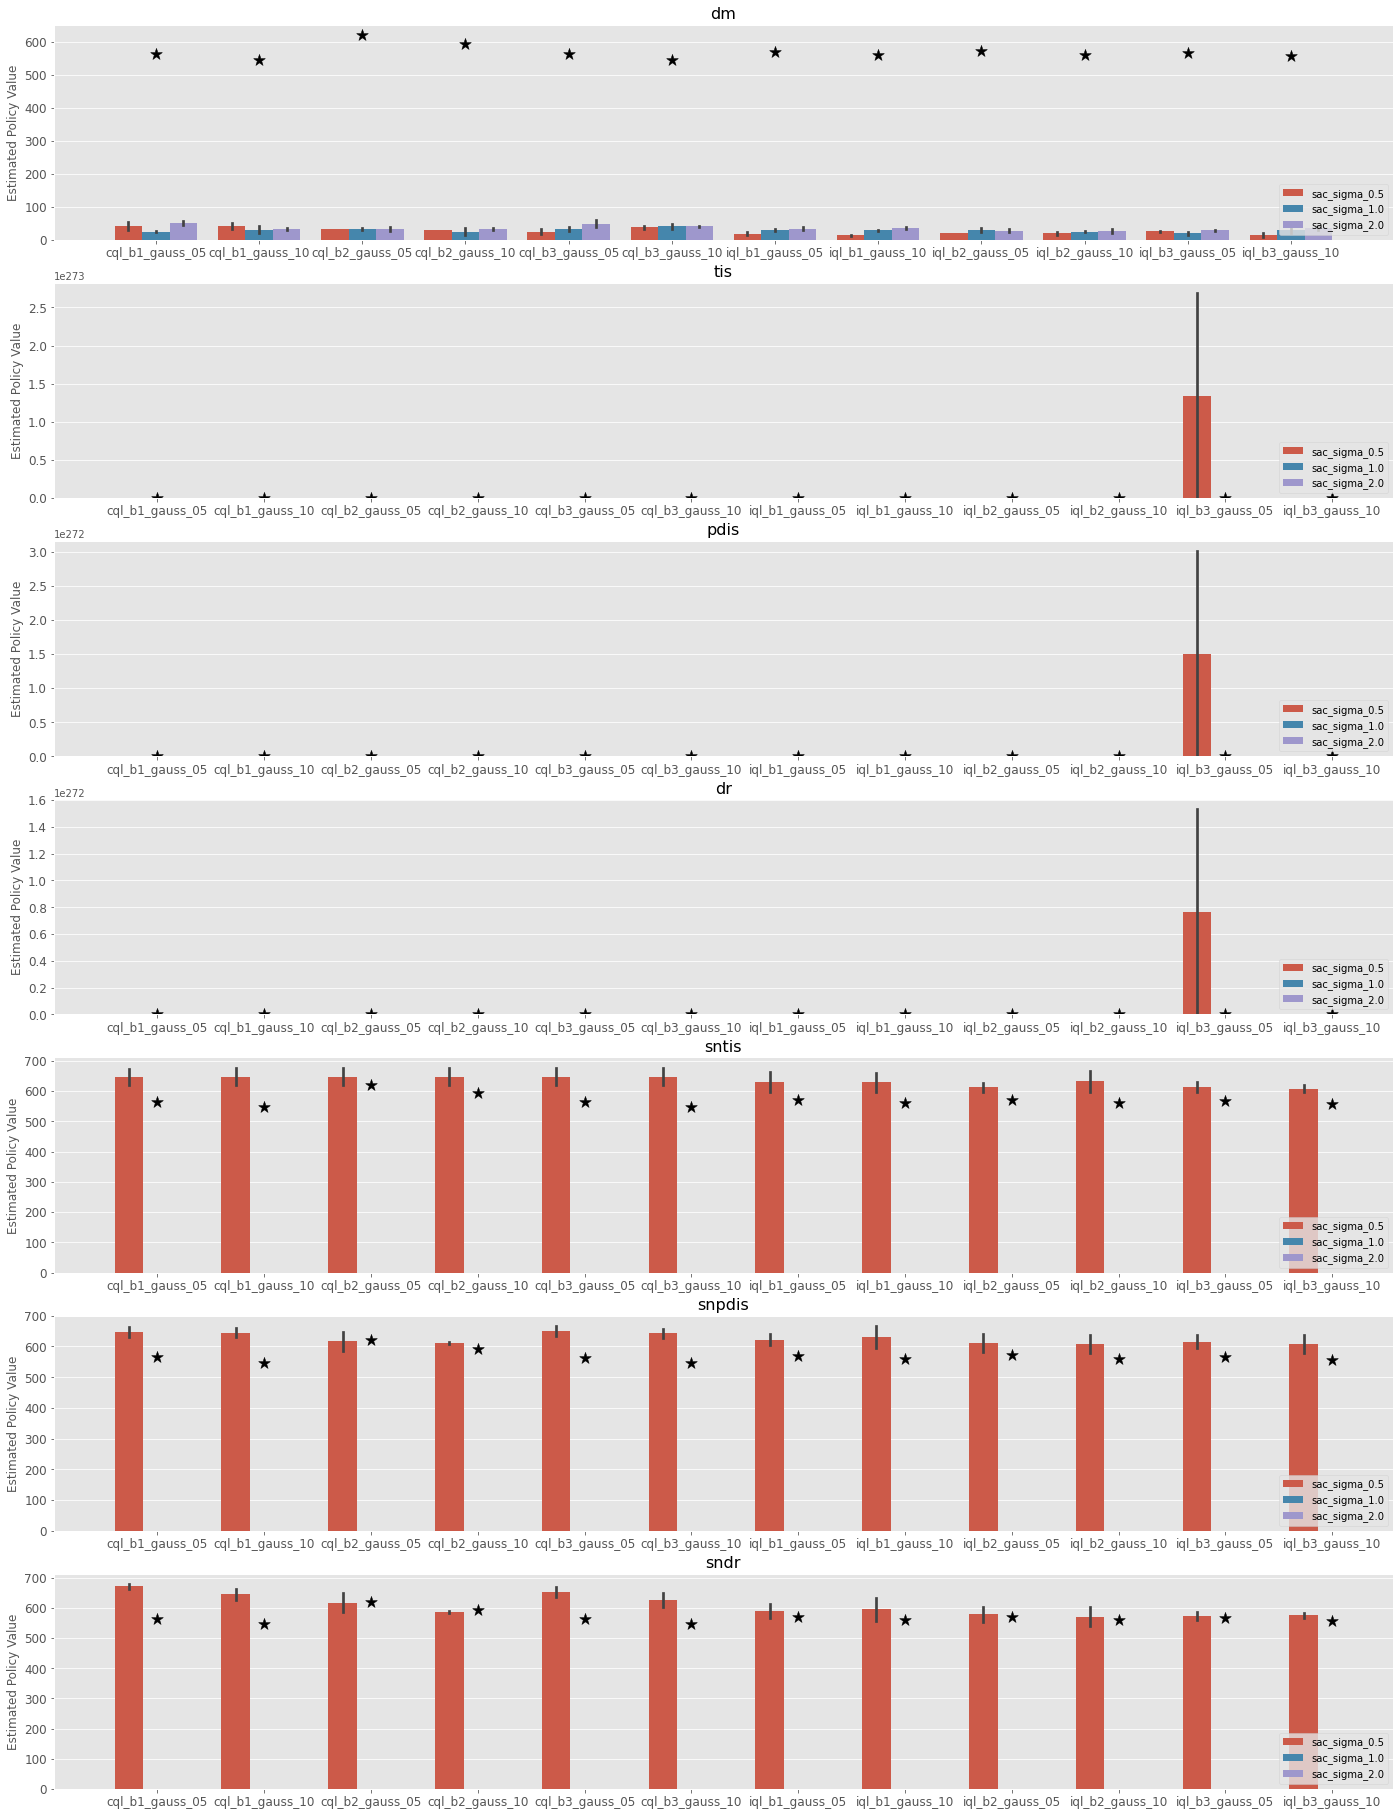

In [ ]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

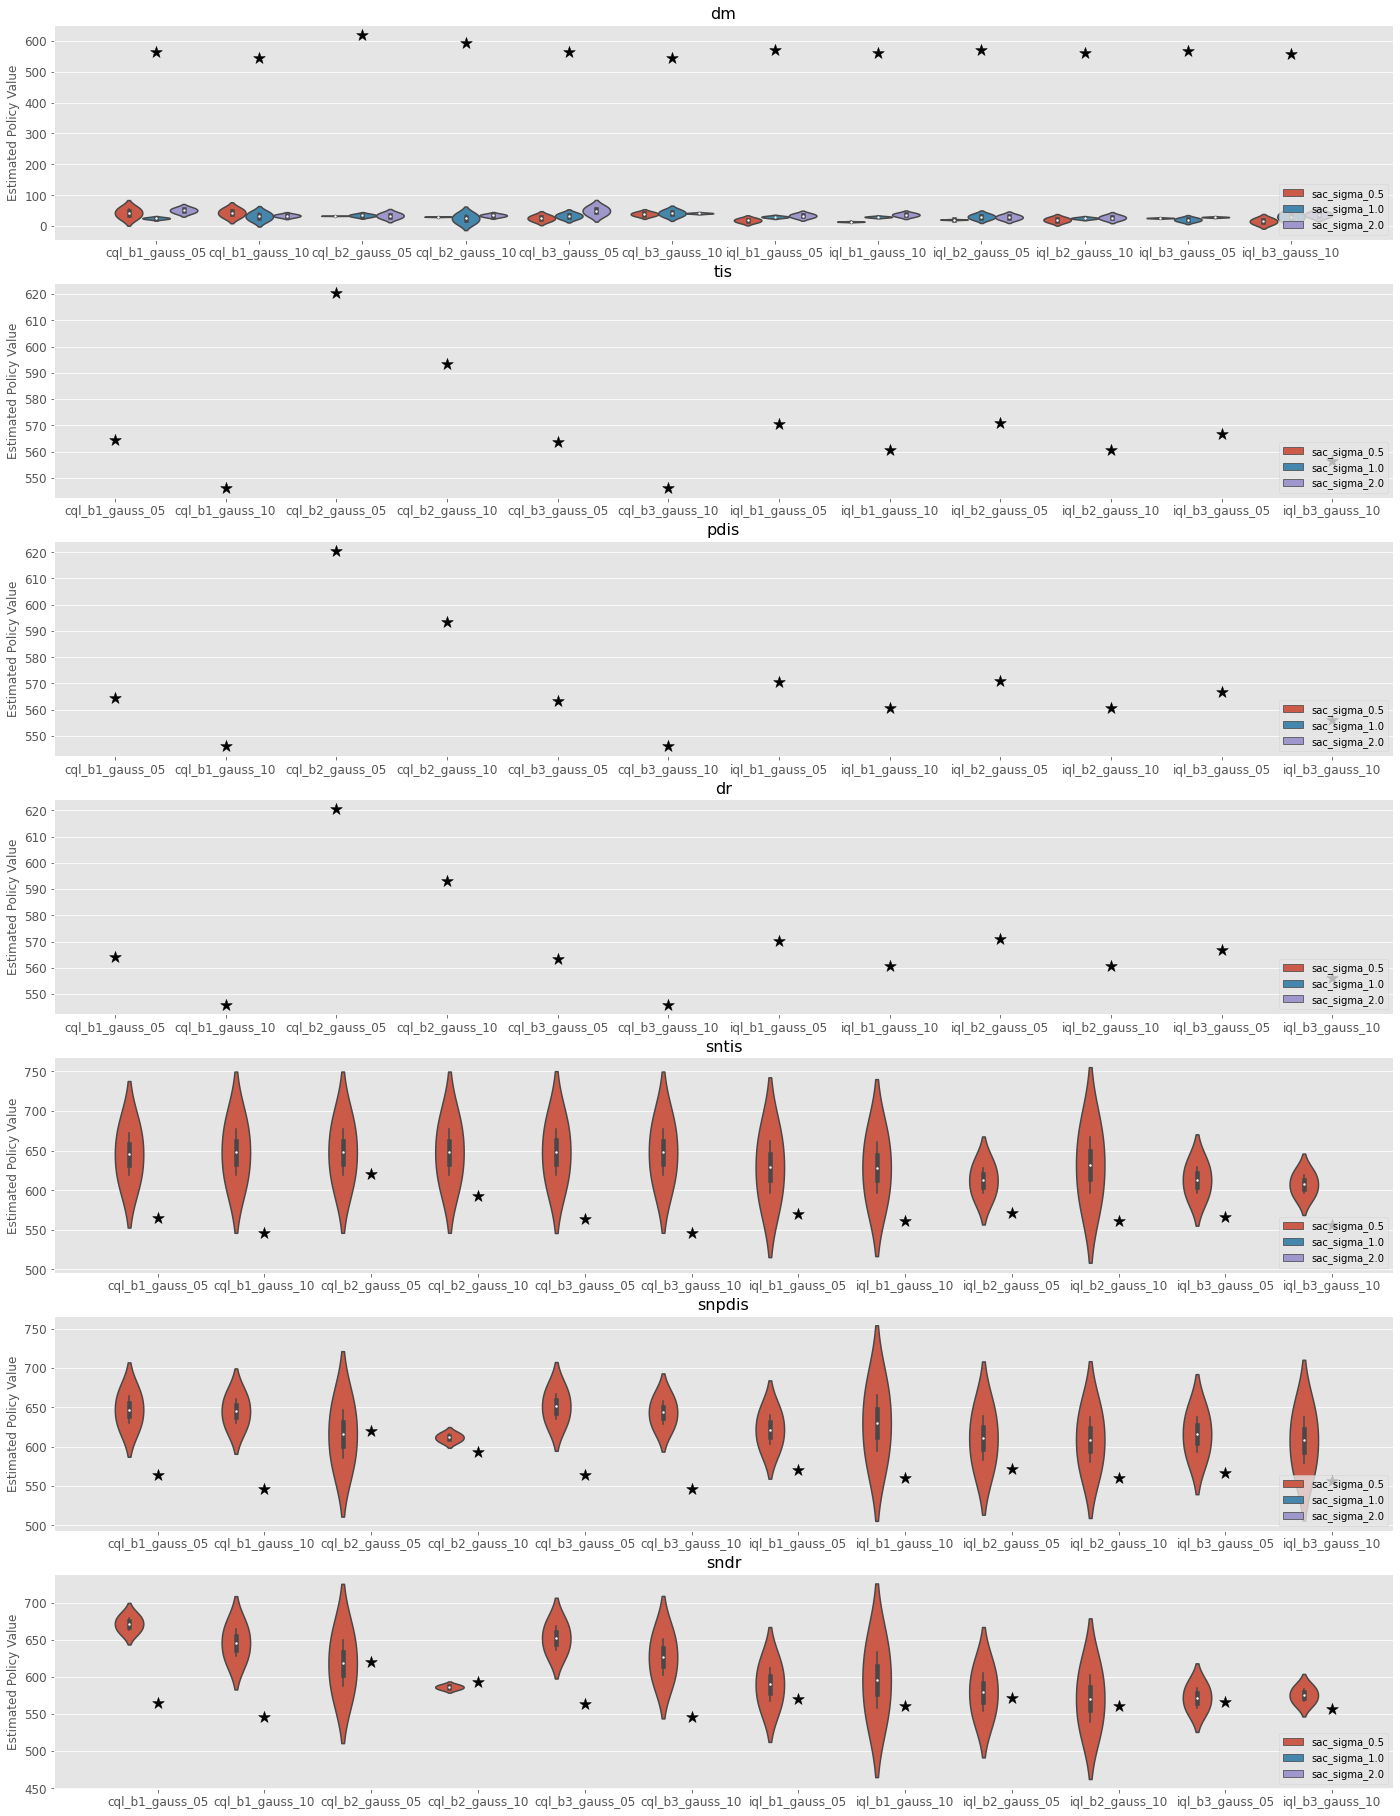

In [ ]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

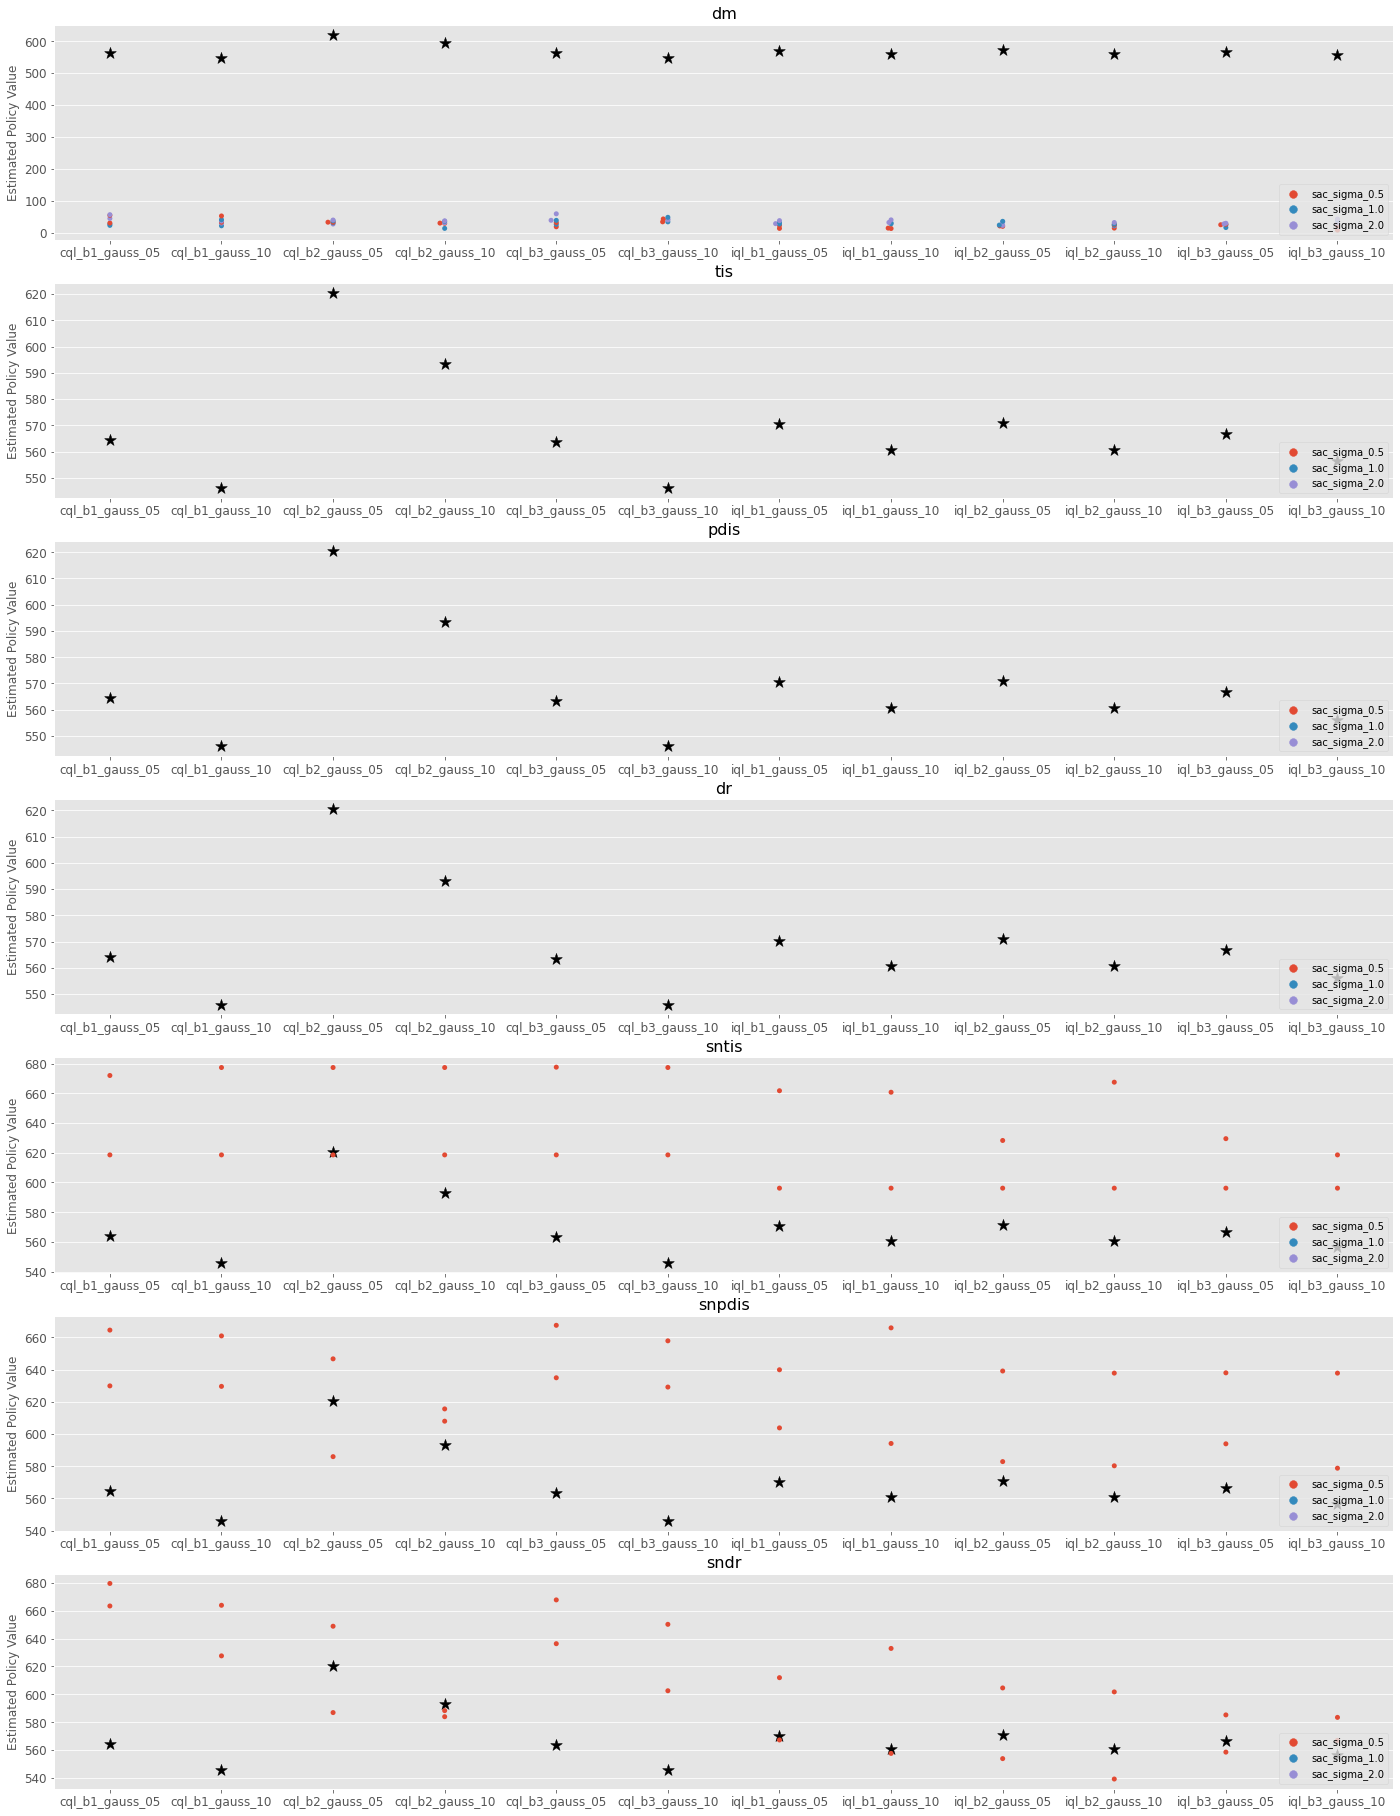

In [ ]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [ ]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import ContinuousCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [ ]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

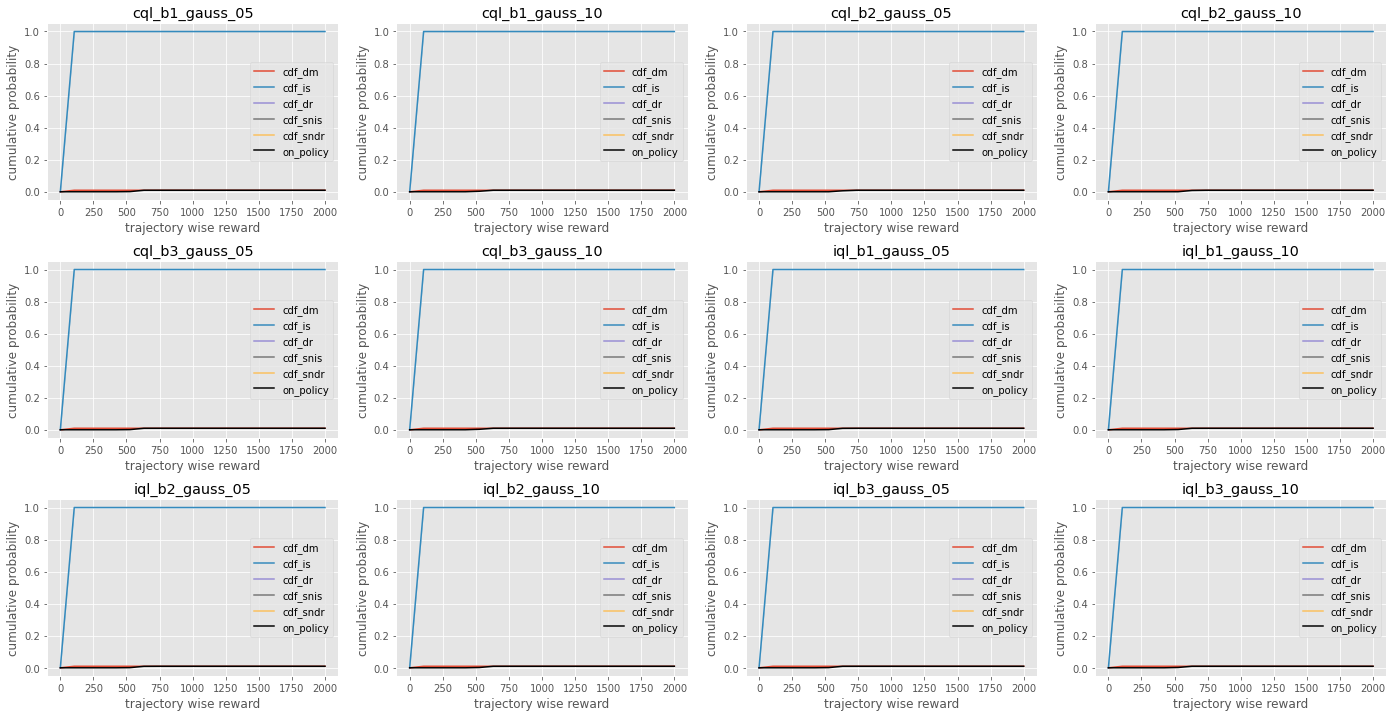

In [ ]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="ci_hue",
    scale_min=0.0, 
    scale_max=2000.0, 
    n_partition=20, 
    n_cols=4,
)

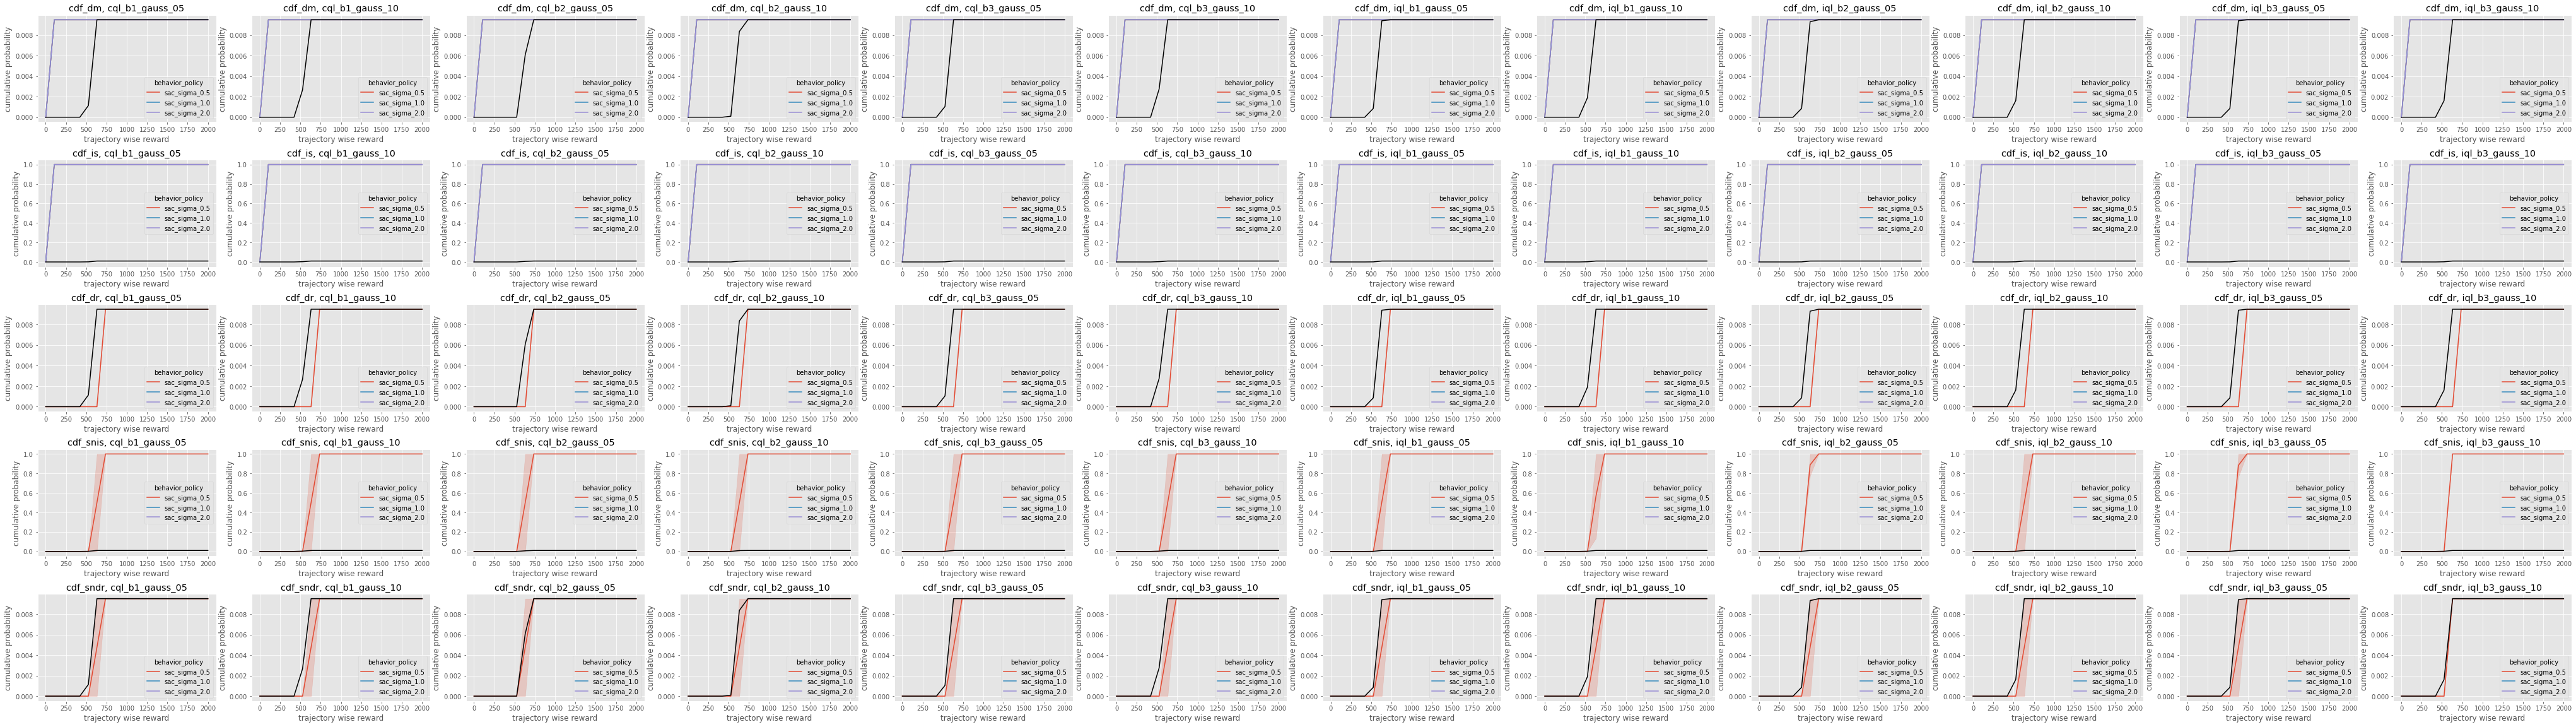

In [ ]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=0.0, 
    scale_max=2000.0, 
    n_partition=20, 
)

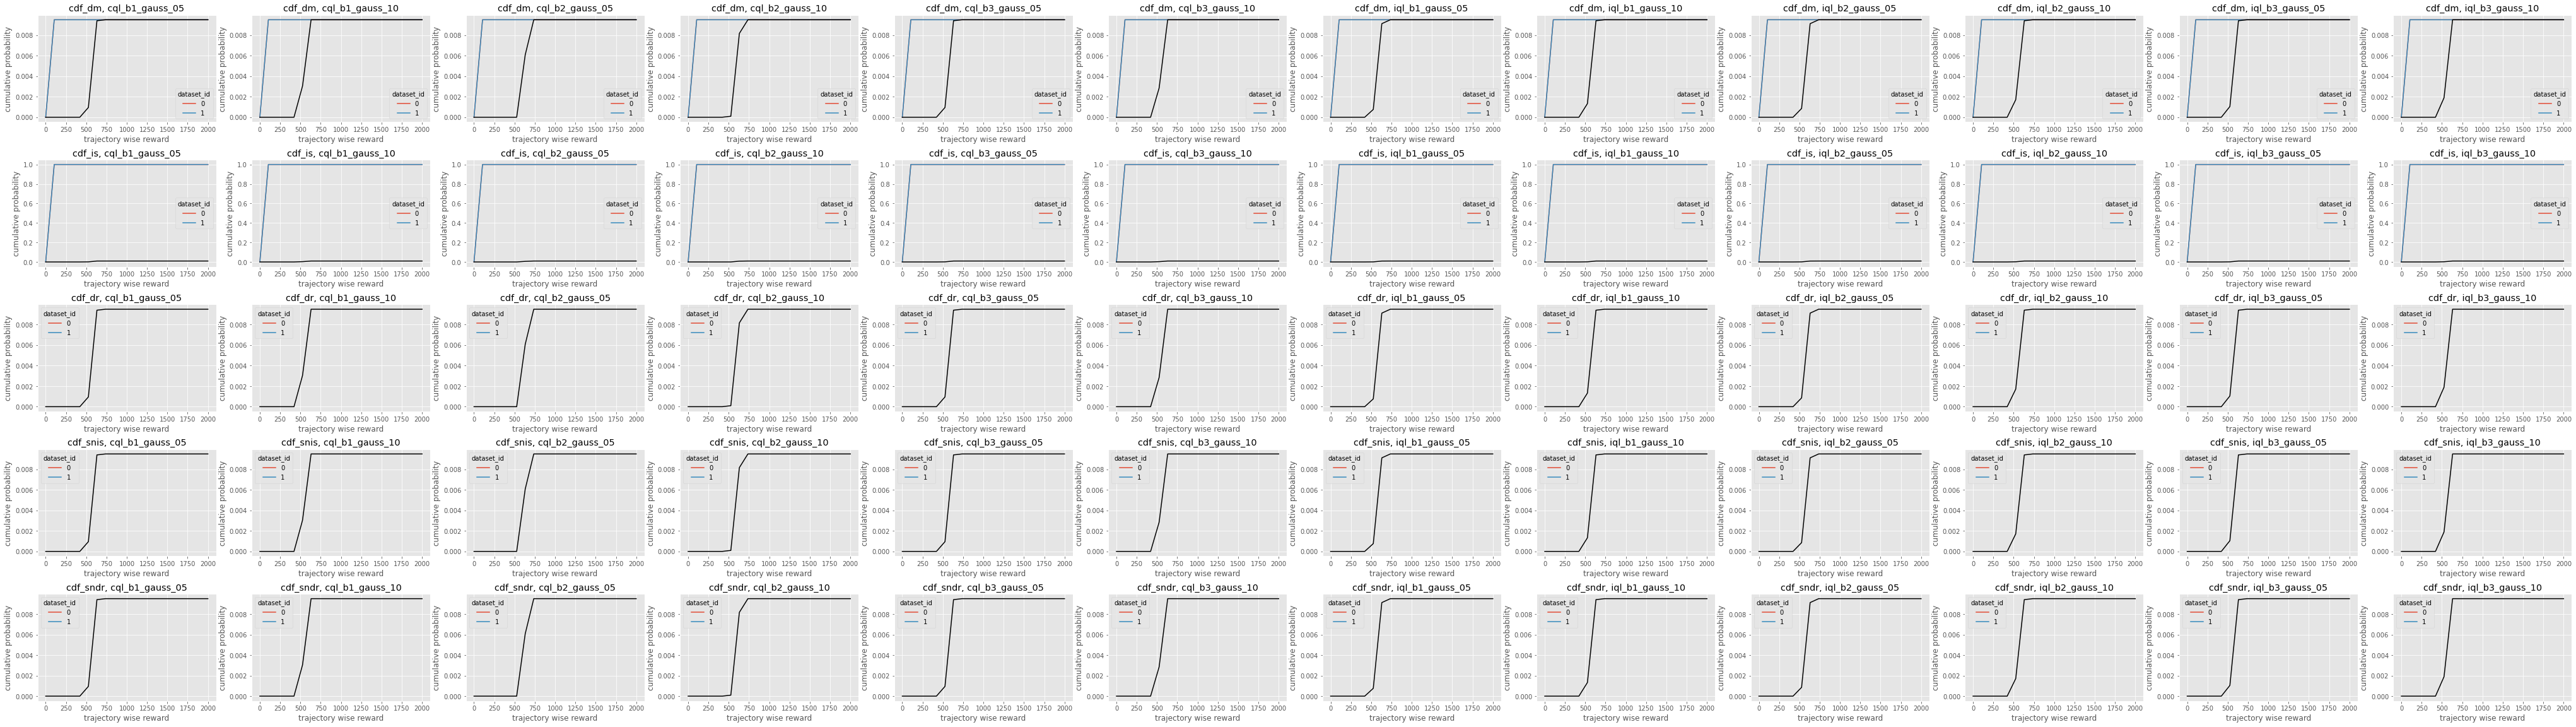

In [ ]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="enumerate",
    hue="policy",
    scale_min=0.0, 
    scale_max=2000.0, 
    n_partition=20, 
)

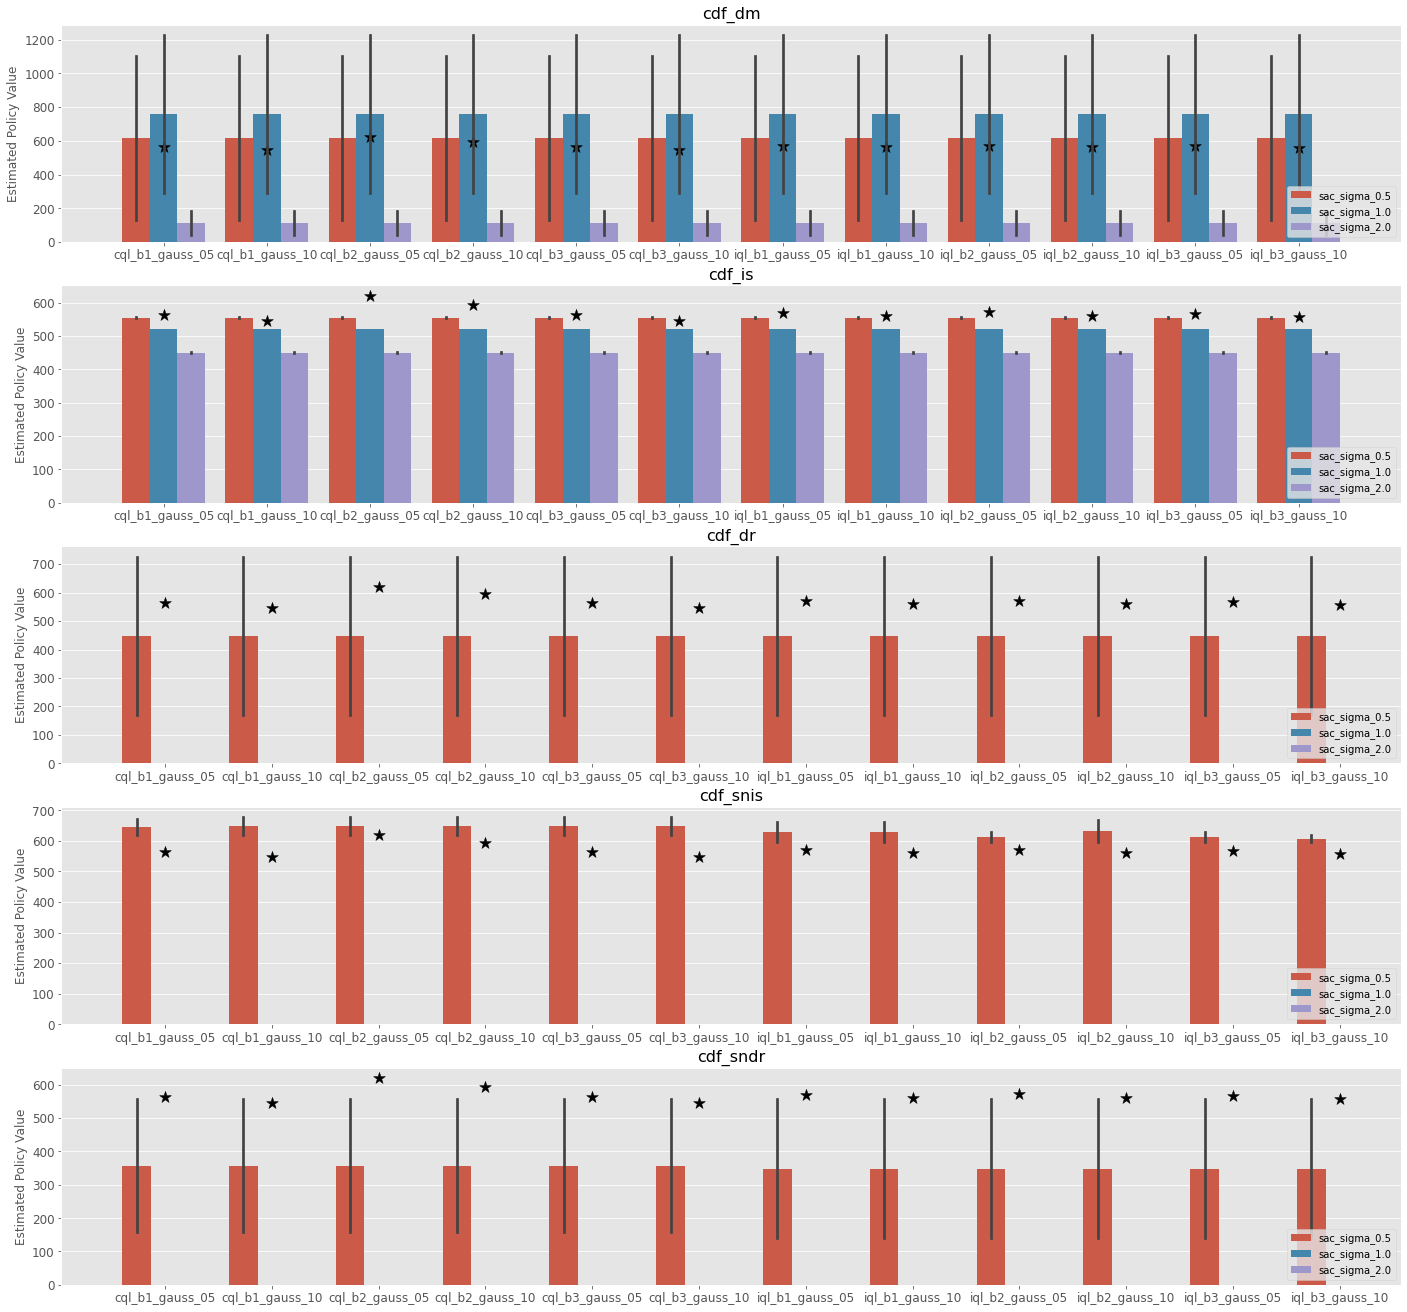

In [ ]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

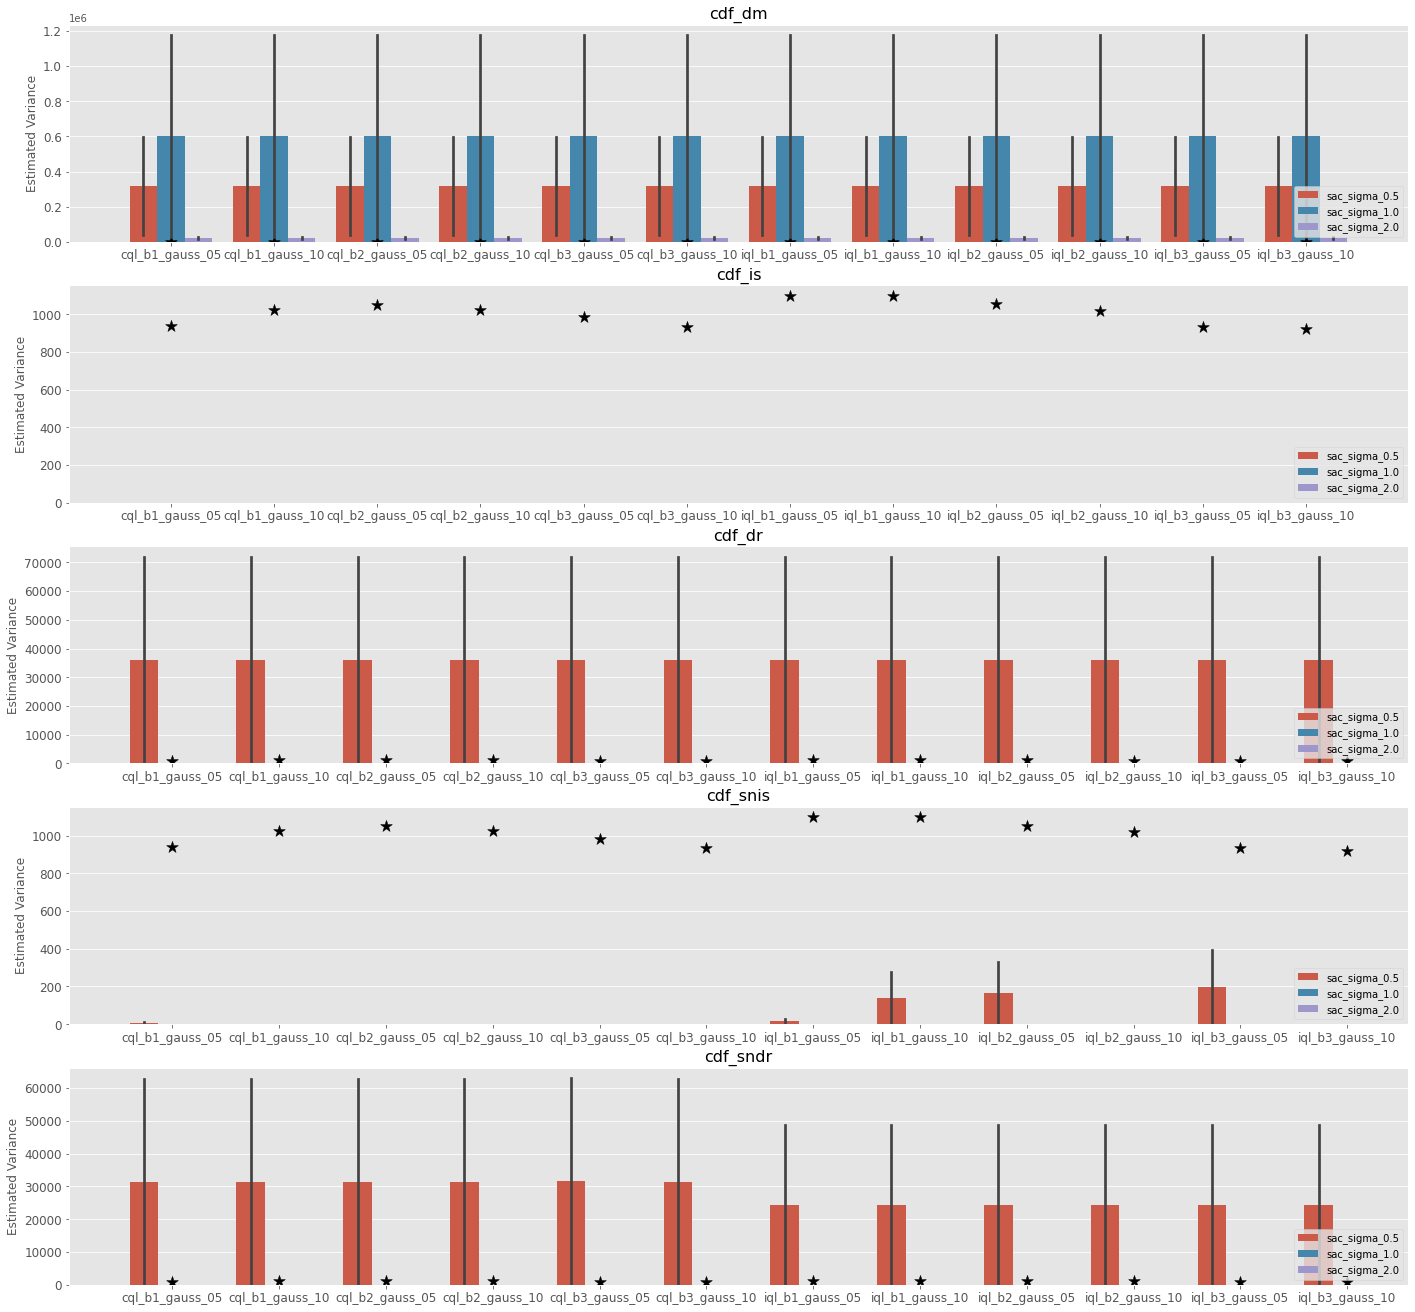

In [ ]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

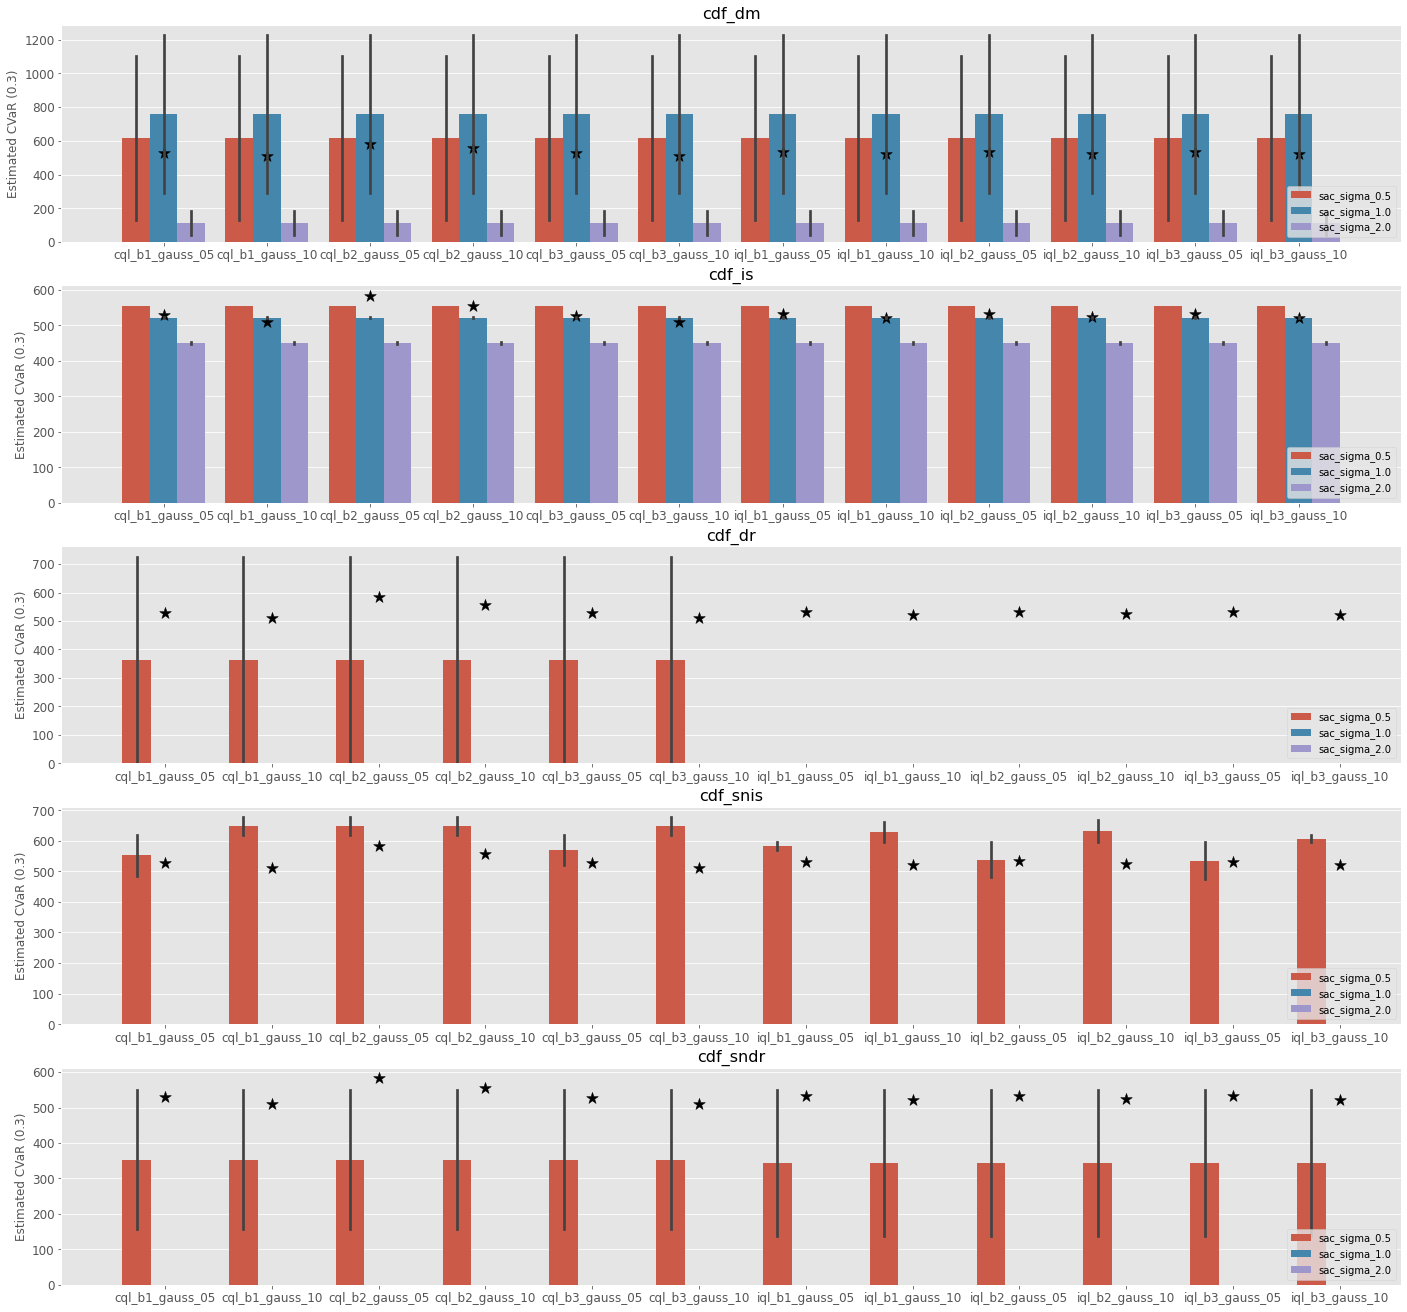

In [ ]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

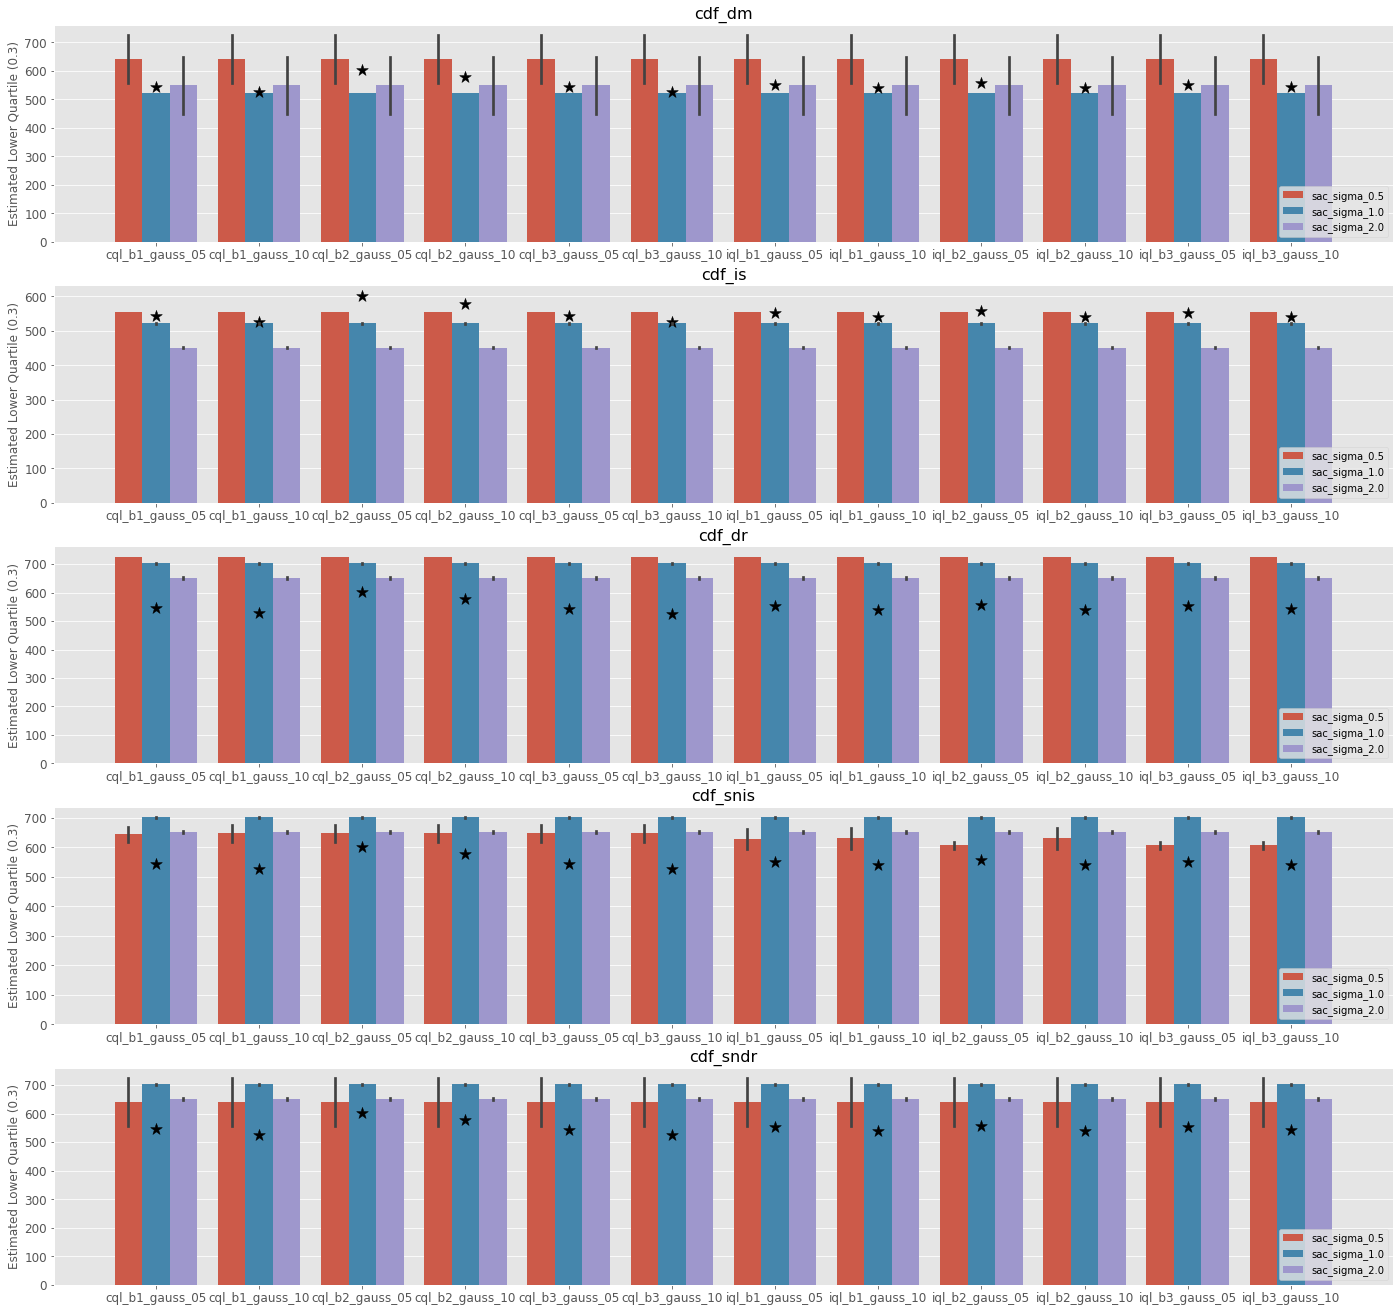

In [ ]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [ ]:
from ofrl.ope import OffPolicySelection

In [ ]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [ ]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result[behavior_policies[0].name][0]

In [ ]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [ ]:
ranking_df[behavior_policies[0].name][0]

In [ ]:
metric_df[behavior_policies[0].name][0]

In [ ]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.75,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.75,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=10.5,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=10.5,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

In [ ]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the continuous action space, please refer to [examples/quickstart/synthetic_synthetic_continuous_multiple_datasets.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.